In [1]:
import os
import sys

path_root = os.path.dirname(os.getcwd())

if path_root not in sys.path:
    sys.path.append(path_root)

In [2]:
from src.config import path_output_synthea, path_output_llm, path_output_extraction, path_output_standardisation
from src.generate.synthea import GenerateSynthea
from src.generate.llm import GenerateLLM
from src.extraction.extraction import Extraction
from src.standardise_extraction.standardise_extraction import StandardiseExtraction
from src.privacy_risk_scorer.privacy_risk_scorer import PrivacyRiskScorer
from src.privacy_risk_explainer.privacy_risk_explainer import PrivacyRiskExplainer

# Privacy Fingerprint End-to-End Overview

The Pipeline has been broken down into four components:
1. **GenerateSynthea**: This generates a list of dictionary of synthetic patient records.
2. **GenerateLLM**: This generates medical notes using the outputs created from **GenerateSynthea**.
3. **Extraction**: This currently uses an LLM that is specialised to extract given entities from the synthetic medical notes produced by **GenerativeLLM**
4. **StandardiseExtraction**: This standardises the results extracted from the medical text.

Each of these classes takes in a path_output, when save_output is set to True, it will save the output to this path_output defined.
These paths have been defined in the src/config.py file:
- path_output_synthea = data_folder + "/synthea.json"
- path_output_llm = data_folder + "/llm.json"
- path_output_extraction = data_folder + "/generative.json"
- path_output_standardisation = data_folder + "/standardisation.json"

Additionally each class will also take a path for the input required to create their output. This allows the user to break-up the pipeline and run from specific points in the pipeline.

## 1. GenerateSynthea: Generating Synthetic Patient Data using Synthea 

Synthea-international is an expansion of Synthea, which is an open-source synthetic patient generator that produces de-identified health records for synthetic patients.

GenerateSynthea is a class used to run Synthea. You will need to follow the instructions on the README to ensure Synthea is installed.
- "./run_synthea" is a command line input that calls to run synthea.
- "-p" is a person flag
- "5" Where 5 determines the number of patients you want to generate. (Alter this to generate more records.)
- "West Yorkshire" Synthea only works on a regional basis, therefore you have to give county information so it can generate address type data.

In the src/config.py there is some given config values:
- path_synthea = "../../synthea" - This defines the location of where synthea is from the src folder.
- path_csv = path_synthea + "/output/csv" - This defines the location where outputs are saved to when synthea is ran.
- path_patients = path_csv + "/patients.csv" - This is a .csv that holds patients synthetic demographic information etc. 
- path_encounters = path_csv + "/encounters.csv" - This is a .csv that holds encounters, i.e., this holds multiple times a patient has gone for medical assessment/treatment.
- cols_patients = ["Id", "BIRTHDATE", "FIRST", "LAST"] - This determines the columns we extract from path_patients.
- cols_encounters = ["PATIENT", "ENCOUNTERCLASS", "REASONDESCRIPTION"] - This defines the columns we extract from path_encounters.

In [ ]:
output_synthea = GenerateSynthea(path_output=path_output_synthea, save_output=True).run("./run_synthea", "-p", "50", "West Yorkshire")
output_synthea

This loads the model from path

In [3]:
output_synthea = GenerateSynthea(path_output=path_output_synthea).load()
output_synthea

[{'NHS_NUMBER': '2441173111',
  'DATE_OF_BIRTH': '2003-07-15',
  'GIVEN_NAME': 'Heike',
  'FAMILY_NAME': 'Bernier',
  'DIAGNOSIS': 'Viral sinusitis (disorder)'},
 {'NHS_NUMBER': '6727219400',
  'DATE_OF_BIRTH': '2001-02-02',
  'GIVEN_NAME': 'Keven',
  'FAMILY_NAME': 'Hammes',
  'DIAGNOSIS': 'Child attention deficit disorder'},
 {'NHS_NUMBER': '9311809187',
  'DATE_OF_BIRTH': '1998-01-06',
  'GIVEN_NAME': 'Kenton',
  'FAMILY_NAME': 'Hermann',
  'DIAGNOSIS': 'Acute bronchitis (disorder)'},
 {'NHS_NUMBER': '6744989936',
  'DATE_OF_BIRTH': '1972-12-23',
  'GIVEN_NAME': 'Darron',
  'FAMILY_NAME': 'Farrell',
  'DIAGNOSIS': 'Anemia (disorder)'},
 {'NHS_NUMBER': '1949271404',
  'DATE_OF_BIRTH': '1968-09-10',
  'GIVEN_NAME': 'Carlo',
  'FAMILY_NAME': 'Kuhn',
  'DIAGNOSIS': 'Chronic pain'},
 {'NHS_NUMBER': '4135716814',
  'DATE_OF_BIRTH': '1991-01-31',
  'GIVEN_NAME': 'Loree',
  'FAMILY_NAME': 'Pouros',
  'DIAGNOSIS': 'Viral sinusitis (disorder)'},
 {'NHS_NUMBER': '5771725080',
  'DATE_OF_BIRTH'

## 2. GenerateLLM: Generating Synthetic Patient Medical Notes 

Currenty GenerateLLM uses Ollama to run a range of pre-trained models you can use.
- model - This determines the model you want to use.
- template - This defines the prompt-template you want to give to the LLM model to generate each patients medical record.

In the src/config.py file, there is a *cols* parameter. This parameter currently maps Synthea column names to names used in the template to generate these medical notes.

```
cols = {
    "NHS_NUMBER": "NHS_NUMBER",
    "BIRTHDATE": "DATE_OF_BIRTH",
    "FIRST": "GIVEN_NAME",
    "LAST": "FAMILY_NAME",
    "REASONDESCRIPTION": "DIAGNOSIS",
}
```

In [ ]:
model = "llama2"
template = """[INST]
<<SYS>>
You are a medical student answering an exam question about writing clinical notes for patients.
<</SYS>>

Keep in mind that your answer will be asssessed based on incorporating all the provided information and the quality of prose.

1. Use prose to write an example clinical note for this patient's doctor.
2. Use less than three sentences.
3. Do not provide a recommendations.
4. Use the following information:

{data}
[/INST]
"""

This runs GenerateLLM using the synthea output from the previous run, and saves the LLM output to the given path_output_llm.

In [ ]:
output_llm =  GenerateLLM(synthea_input=output_synthea, path_output=path_output_llm, save_output=True).run(model, template)
output_llm

This runs GenerateLLM using a pre-saved synthea output saved at path_output_synthea, and generates a local output_llm. In comparison to the run above this will produce slightly different results.

In [ ]:
output_llm =  GenerateLLM(synthea_path=path_output_synthea, path_output=path_output_llm, save_output=False).run(model, template)
output_llm

This loads the current saved output at path_output_llm.

In [4]:
output_llm =  GenerateLLM(path_output=path_output_llm).load()
output_llm

["Clinical Note:\nPatient Name: Heike Bernier\nNHS Number: 2441173111\nDate of Birth: July 15, 2003\n\nChief Complaint: Fever, headache, and nasal congestion for 3 days.\n\nHistory of Present Illness: The patient was seen in the emergency department with symptoms of viral sinusitis. She reported a fever of 102°F, headache, and nasal congestion for the past 3 days. The patient also mentioned that she had been experiencing postnasal drip and sore throat.\n\nAssessment: The patient's temperature was normalized with acetaminophen, and her symptoms improved marginally. However, her nasal congestion persisted. A viral sinusitis diagnosis was made based on the patient's symptoms and medical history. Recommendations included bed rest, over-the-counter decongestants, and antiviral medication if necessary.\n\nPlan: Monitor the patient's condition closely and reassess in 24-48 hours for further evaluation or treatment as needed.",
 ' Clinical Note:\nPatient: Keven Hammes\nNHS Number: 6727219400\n

## 3. Extraction: Re-extracting Entities from the Patient Medical Notes

This uses a local quanitised UniversalNER model to extract entities from the synthetic medical notes. You will need to follow the README to host the UniversalNER model locally.

In the src/config file:
- entity_list = ["person", "nhs number", "date of birth", "diagnosis"] - This is the list of entities you want to extract from the synthetic medical notes.
- universal_ner_path = "../models/quantized_q4_1.gguf" - This is the path to the quantized universal model located in a models folder on the top level of this repo.

This runs the extraction class from an output generated in this notebook, and is save the extraction output to the path given.

In [17]:
output_extraction = Extraction(llm_input=output_llm, path_output=path_output_extraction, save_output=True).run()
output_extraction

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from ../models/quantized_q4_1.gguf (version GGUF V3 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q4_1     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q4_1     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q4_1     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q4_1     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q4_1     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q4_1     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    6:            blk.0.ffn_down.weight q4_1     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    7:              blk.0.ffn_up.weight q4_1     [  4096, 11008,     1,     1

 ["Heike Bernier"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.78 ms /     7 runs   (    0.11 ms per token,  8939.97 tokens per second)
llama_print_timings: prompt eval time =   10070.55 ms /   323 tokens (   31.18 ms per token,    32.07 tokens per second)
llama_print_timings:        eval time =     552.98 ms /     6 runs   (   92.16 ms per token,    10.85 tokens per second)
llama_print_timings:       total time =   10647.19 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.54 ms /     6 runs   (    0.09 ms per token, 11131.73 tokens per second)
llama_print_timings: prompt eval time =     264.27 ms /    25 tokens (   10.57 ms per token,    94.60 tokens per second)
llama_print_timings:        eval time =     450.71 ms /     5 runs   (   90.14 ms per token,    11.09 tokens per second)
llama_print_timings:       total time =     740.22 ms
Llama.generate: prefix-match hit


 ["July 15, 2003"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.89 ms /    14 runs   (    0.14 ms per token,  7395.67 tokens per second)
llama_print_timings: prompt eval time =     265.48 ms /    25 tokens (   10.62 ms per token,    94.17 tokens per second)
llama_print_timings:        eval time =    1185.26 ms /    13 runs   (   91.17 ms per token,    10.97 tokens per second)
llama_print_timings:       total time =    1497.14 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.96 ms /     8 runs   (    0.12 ms per token,  8298.76 tokens per second)
llama_print_timings: prompt eval time =     274.59 ms /    24 tokens (   11.44 ms per token,    87.40 tokens per second)
llama_print_timings:        eval time =     621.36 ms /     7 runs   (   88.77 ms per token,    11.27 tokens per second)
llama_print_timings:       total time =     913.58 ms
Llama.generate: prefix-match hit


 ["Keven Hammes"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.51 ms /     7 runs   (    0.22 ms per token,  4638.83 tokens per second)
llama_print_timings: prompt eval time =    1244.14 ms /   160 tokens (    7.78 ms per token,   128.60 tokens per second)
llama_print_timings:        eval time =     531.34 ms /     6 runs   (   88.56 ms per token,    11.29 tokens per second)
llama_print_timings:       total time =    1801.29 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.06 ms /     6 runs   (    0.18 ms per token,  5665.72 tokens per second)
llama_print_timings: prompt eval time =     261.96 ms /    25 tokens (   10.48 ms per token,    95.43 tokens per second)
llama_print_timings:        eval time =     431.67 ms /     5 runs   (   86.33 ms per token,    11.58 tokens per second)
llama_print_timings:       total time =     714.12 ms
Llama.generate: prefix-match hit


 ["February 2, 2001"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.99 ms /    14 runs   (    0.14 ms per token,  7035.18 tokens per second)
llama_print_timings: prompt eval time =     261.41 ms /    25 tokens (   10.46 ms per token,    95.64 tokens per second)
llama_print_timings:        eval time =    1141.49 ms /    13 runs   (   87.81 ms per token,    11.39 tokens per second)
llama_print_timings:       total time =    1443.07 ms
Llama.generate: prefix-match hit


 ["ADHD"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.54 ms /     5 runs   (    0.11 ms per token,  9328.36 tokens per second)
llama_print_timings: prompt eval time =     270.09 ms /    24 tokens (   11.25 ms per token,    88.86 tokens per second)
llama_print_timings:        eval time =     347.53 ms /     4 runs   (   86.88 ms per token,    11.51 tokens per second)
llama_print_timings:       total time =     628.69 ms
Llama.generate: prefix-match hit


 ["Mr. Kenton Hermann"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.86 ms /     8 runs   (    0.11 ms per token,  9302.33 tokens per second)
llama_print_timings: prompt eval time =     989.70 ms /   127 tokens (    7.79 ms per token,   128.32 tokens per second)
llama_print_timings:        eval time =     640.24 ms /     7 runs   (   91.46 ms per token,    10.93 tokens per second)
llama_print_timings:       total time =    1646.88 ms
Llama.generate: prefix-match hit


 ["NHS number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6198.35 tokens per second)
llama_print_timings: prompt eval time =     264.03 ms /    25 tokens (   10.56 ms per token,    94.69 tokens per second)
llama_print_timings:        eval time =     428.54 ms /     5 runs   (   85.71 ms per token,    11.67 tokens per second)
llama_print_timings:       total time =     708.32 ms
Llama.generate: prefix-match hit


 ["January 6th, 1998"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.91 ms /    15 runs   (    0.13 ms per token,  7845.19 tokens per second)
llama_print_timings: prompt eval time =     262.54 ms /    25 tokens (   10.50 ms per token,    95.22 tokens per second)
llama_print_timings:        eval time =    1299.48 ms /    14 runs   (   92.82 ms per token,    10.77 tokens per second)
llama_print_timings:       total time =    1602.03 ms
Llama.generate: prefix-match hit


 ["acute bronchitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.25 ms /     8 runs   (    0.16 ms per token,  6415.40 tokens per second)
llama_print_timings: prompt eval time =     262.69 ms /    24 tokens (   10.95 ms per token,    91.36 tokens per second)
llama_print_timings:        eval time =     603.18 ms /     7 runs   (   86.17 ms per token,    11.61 tokens per second)
llama_print_timings:       total time =     886.57 ms
Llama.generate: prefix-match hit


 ["Darron Farrell"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.71 ms /     8 runs   (    0.21 ms per token,  4675.63 tokens per second)
llama_print_timings: prompt eval time =    2879.87 ms /   331 tokens (    8.70 ms per token,   114.94 tokens per second)
llama_print_timings:        eval time =     617.15 ms /     7 runs   (   88.16 ms per token,    11.34 tokens per second)
llama_print_timings:       total time =    3527.41 ms
Llama.generate: prefix-match hit


 ["6744989936"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.55 ms /    13 runs   (    0.20 ms per token,  5100.04 tokens per second)
llama_print_timings: prompt eval time =     265.58 ms /    25 tokens (   10.62 ms per token,    94.13 tokens per second)
llama_print_timings:        eval time =    1084.45 ms /    12 runs   (   90.37 ms per token,    11.07 tokens per second)
llama_print_timings:       total time =    1396.33 ms
Llama.generate: prefix-match hit


 ["December 23, 1972"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.52 ms /    14 runs   (    0.18 ms per token,  5562.18 tokens per second)
llama_print_timings: prompt eval time =     278.46 ms /    25 tokens (   11.14 ms per token,    89.78 tokens per second)
llama_print_timings:        eval time =    1245.11 ms /    13 runs   (   95.78 ms per token,    10.44 tokens per second)
llama_print_timings:       total time =    1569.63 ms
Llama.generate: prefix-match hit


 ["Anemia"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.64 ms /     5 runs   (    0.13 ms per token,  7836.99 tokens per second)
llama_print_timings: prompt eval time =     273.50 ms /    24 tokens (   11.40 ms per token,    87.75 tokens per second)
llama_print_timings:        eval time =     357.26 ms /     4 runs   (   89.32 ms per token,    11.20 tokens per second)
llama_print_timings:       total time =     642.67 ms
Llama.generate: prefix-match hit


 ["Carlo Kuhn"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.70 ms /     7 runs   (    0.10 ms per token,  9971.51 tokens per second)
llama_print_timings: prompt eval time =    1772.06 ms /   220 tokens (    8.05 ms per token,   124.15 tokens per second)
llama_print_timings:        eval time =     521.52 ms /     6 runs   (   86.92 ms per token,    11.50 tokens per second)
llama_print_timings:       total time =    2313.13 ms
Llama.generate: prefix-match hit


 ["1949271404"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.76 ms /    13 runs   (    0.14 ms per token,  7386.36 tokens per second)
llama_print_timings: prompt eval time =     264.32 ms /    25 tokens (   10.57 ms per token,    94.58 tokens per second)
llama_print_timings:        eval time =    1129.85 ms /    12 runs   (   94.15 ms per token,    10.62 tokens per second)
llama_print_timings:       total time =    1427.56 ms
Llama.generate: prefix-match hit


 ["September 10, 1968"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.02 ms /    14 runs   (    0.29 ms per token,  3479.99 tokens per second)
llama_print_timings: prompt eval time =     272.36 ms /    25 tokens (   10.89 ms per token,    91.79 tokens per second)
llama_print_timings:        eval time =    1130.16 ms /    13 runs   (   86.94 ms per token,    11.50 tokens per second)
llama_print_timings:       total time =    1463.80 ms
Llama.generate: prefix-match hit


 ["fibromyalgia", "degenerative disc disease"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.49 ms /    15 runs   (    0.17 ms per token,  6024.10 tokens per second)
llama_print_timings: prompt eval time =     262.39 ms /    24 tokens (   10.93 ms per token,    91.47 tokens per second)
llama_print_timings:        eval time =    1304.61 ms /    14 runs   (   93.19 ms per token,    10.73 tokens per second)
llama_print_timings:       total time =    1614.30 ms
Llama.generate: prefix-match hit


 ["Loree Pouros"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.53 ms /     9 runs   (    0.28 ms per token,  3557.31 tokens per second)
llama_print_timings: prompt eval time =    1494.49 ms /   190 tokens (    7.87 ms per token,   127.13 tokens per second)
llama_print_timings:        eval time =     691.58 ms /     8 runs   (   86.45 ms per token,    11.57 tokens per second)
llama_print_timings:       total time =    2223.60 ms
Llama.generate: prefix-match hit


 ["4135716814"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.19 ms /    13 runs   (    0.25 ms per token,  4073.96 tokens per second)
llama_print_timings: prompt eval time =     258.59 ms /    25 tokens (   10.34 ms per token,    96.68 tokens per second)
llama_print_timings:        eval time =    1055.55 ms /    12 runs   (   87.96 ms per token,    11.37 tokens per second)
llama_print_timings:       total time =    1365.92 ms
Llama.generate: prefix-match hit


 ["January 31st, 1991"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.88 ms /    16 runs   (    0.12 ms per token,  8506.11 tokens per second)
llama_print_timings: prompt eval time =     266.24 ms /    25 tokens (   10.65 ms per token,    93.90 tokens per second)
llama_print_timings:        eval time =    1409.55 ms /    15 runs   (   93.97 ms per token,    10.64 tokens per second)
llama_print_timings:       total time =    1717.29 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.33 ms /     8 runs   (    0.17 ms per token,  6010.52 tokens per second)
llama_print_timings: prompt eval time =     262.82 ms /    24 tokens (   10.95 ms per token,    91.32 tokens per second)
llama_print_timings:        eval time =     644.25 ms /     7 runs   (   92.04 ms per token,    10.87 tokens per second)
llama_print_timings:       total time =     927.89 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.32 ms /     2 runs   (    0.16 ms per token,  6289.31 tokens per second)
llama_print_timings: prompt eval time =    1772.91 ms /   213 tokens (    8.32 ms per token,   120.14 tokens per second)
llama_print_timings:        eval time =     105.46 ms /     1 runs   (  105.46 ms per token,     9.48 tokens per second)
llama_print_timings:       total time =    1885.03 ms
Llama.generate: prefix-match hit


 ["5771725080"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.40 ms /    13 runs   (    0.26 ms per token,  3829.16 tokens per second)
llama_print_timings: prompt eval time =     275.63 ms /    25 tokens (   11.03 ms per token,    90.70 tokens per second)
llama_print_timings:        eval time =    1139.31 ms /    12 runs   (   94.94 ms per token,    10.53 tokens per second)
llama_print_timings:       total time =    1463.79 ms
Llama.generate: prefix-match hit


 ["Date of Birth"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.01 ms /     7 runs   (    0.29 ms per token,  3480.86 tokens per second)
llama_print_timings: prompt eval time =     265.02 ms /    25 tokens (   10.60 ms per token,    94.33 tokens per second)
llama_print_timings:        eval time =     530.04 ms /     6 runs   (   88.34 ms per token,    11.32 tokens per second)
llama_print_timings:       total time =     822.58 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.88 ms /     2 runs   (    0.44 ms per token,  2277.90 tokens per second)
llama_print_timings: prompt eval time =     259.94 ms /    24 tokens (   10.83 ms per token,    92.33 tokens per second)
llama_print_timings:        eval time =      83.90 ms /     1 runs   (   83.90 ms per token,    11.92 tokens per second)
llama_print_timings:       total time =     354.17 ms
Llama.generate: prefix-match hit


 ["Tommy Murray"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.06 ms /     6 runs   (    0.18 ms per token,  5671.08 tokens per second)
llama_print_timings: prompt eval time =    1480.59 ms /   183 tokens (    8.09 ms per token,   123.60 tokens per second)
llama_print_timings:        eval time =     442.44 ms /     5 runs   (   88.49 ms per token,    11.30 tokens per second)
llama_print_timings:       total time =    1940.65 ms
Llama.generate: prefix-match hit


 ["8556129943"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.35 ms /    13 runs   (    0.33 ms per token,  2988.51 tokens per second)
llama_print_timings: prompt eval time =     261.09 ms /    25 tokens (   10.44 ms per token,    95.75 tokens per second)
llama_print_timings:        eval time =    1029.00 ms /    12 runs   (   85.75 ms per token,    11.66 tokens per second)
llama_print_timings:       total time =    1366.81 ms
Llama.generate: prefix-match hit


 ["December 30, 2009"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.31 ms /    14 runs   (    0.38 ms per token,  2637.03 tokens per second)
llama_print_timings: prompt eval time =     260.99 ms /    25 tokens (   10.44 ms per token,    95.79 tokens per second)
llama_print_timings:        eval time =    1118.22 ms /    13 runs   (   86.02 ms per token,    11.63 tokens per second)
llama_print_timings:       total time =    1455.06 ms
Llama.generate: prefix-match hit


 ["acute bronchitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.47 ms /     8 runs   (    0.43 ms per token,  2308.14 tokens per second)
llama_print_timings: prompt eval time =     259.03 ms /    24 tokens (   10.79 ms per token,    92.65 tokens per second)
llama_print_timings:        eval time =     608.68 ms /     7 runs   (   86.95 ms per token,    11.50 tokens per second)
llama_print_timings:       total time =     914.40 ms
Llama.generate: prefix-match hit


 ["Christia Torphy"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.01 ms /     7 runs   (    0.29 ms per token,  3489.53 tokens per second)
llama_print_timings: prompt eval time =    3148.36 ms /   365 tokens (    8.63 ms per token,   115.93 tokens per second)
llama_print_timings:        eval time =     529.07 ms /     6 runs   (   88.18 ms per token,    11.34 tokens per second)
llama_print_timings:       total time =    3710.67 ms
Llama.generate: prefix-match hit


 ["9217912255"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.43 ms /    13 runs   (    0.34 ms per token,  2936.53 tokens per second)
llama_print_timings: prompt eval time =     265.69 ms /    25 tokens (   10.63 ms per token,    94.10 tokens per second)
llama_print_timings:        eval time =    1055.62 ms /    12 runs   (   87.97 ms per token,    11.37 tokens per second)
llama_print_timings:       total time =    1384.41 ms
Llama.generate: prefix-match hit


 ["September 9, 1956"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.80 ms /    13 runs   (    0.37 ms per token,  2710.03 tokens per second)
llama_print_timings: prompt eval time =     265.08 ms /    25 tokens (   10.60 ms per token,    94.31 tokens per second)
llama_print_timings:        eval time =    1081.83 ms /    12 runs   (   90.15 ms per token,    11.09 tokens per second)
llama_print_timings:       total time =    1410.95 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.96 ms /     8 runs   (    0.37 ms per token,  2707.28 tokens per second)
llama_print_timings: prompt eval time =     262.51 ms /    24 tokens (   10.94 ms per token,    91.43 tokens per second)
llama_print_timings:        eval time =     613.37 ms /     7 runs   (   87.62 ms per token,    11.41 tokens per second)
llama_print_timings:       total time =     915.00 ms
Llama.generate: prefix-match hit


 ["Vannessa Boyle", "Mrs. Boyle"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.93 ms /    15 runs   (    0.33 ms per token,  3041.36 tokens per second)
llama_print_timings: prompt eval time =    1983.93 ms /   234 tokens (    8.48 ms per token,   117.95 tokens per second)
llama_print_timings:        eval time =    1193.82 ms /    14 runs   (   85.27 ms per token,    11.73 tokens per second)
llama_print_timings:       total time =    3255.28 ms
Llama.generate: prefix-match hit


 ["3523937671"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.67 ms /    13 runs   (    0.36 ms per token,  2780.75 tokens per second)
llama_print_timings: prompt eval time =     261.01 ms /    25 tokens (   10.44 ms per token,    95.78 tokens per second)
llama_print_timings:        eval time =    1010.98 ms /    12 runs   (   84.25 ms per token,    11.87 tokens per second)
llama_print_timings:       total time =    1349.26 ms
Llama.generate: prefix-match hit


 ["July 20, 1974"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.45 ms /    14 runs   (    0.32 ms per token,  3144.65 tokens per second)
llama_print_timings: prompt eval time =     263.12 ms /    25 tokens (   10.52 ms per token,    95.01 tokens per second)
llama_print_timings:        eval time =    1102.98 ms /    13 runs   (   84.84 ms per token,    11.79 tokens per second)
llama_print_timings:       total time =    1447.05 ms
Llama.generate: prefix-match hit


 ["Sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.12 ms /     6 runs   (    0.19 ms per token,  5338.08 tokens per second)
llama_print_timings: prompt eval time =     260.43 ms /    24 tokens (   10.85 ms per token,    92.16 tokens per second)
llama_print_timings:        eval time =     428.73 ms /     5 runs   (   85.75 ms per token,    11.66 tokens per second)
llama_print_timings:       total time =     709.01 ms
Llama.generate: prefix-match hit


 ["Ms. Jeanelle Stanton"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.02 ms /    10 runs   (    0.10 ms per token,  9832.84 tokens per second)
llama_print_timings: prompt eval time =    2437.58 ms /   287 tokens (    8.49 ms per token,   117.74 tokens per second)
llama_print_timings:        eval time =     862.32 ms /     9 runs   (   95.81 ms per token,    10.44 tokens per second)
llama_print_timings:       total time =    3322.31 ms
Llama.generate: prefix-match hit


 ["0982637659"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.45 ms /    13 runs   (    0.11 ms per token,  8971.70 tokens per second)
llama_print_timings: prompt eval time =     262.76 ms /    25 tokens (   10.51 ms per token,    95.14 tokens per second)
llama_print_timings:        eval time =    1117.99 ms /    12 runs   (   93.17 ms per token,    10.73 tokens per second)
llama_print_timings:       total time =    1418.11 ms
Llama.generate: prefix-match hit


 ["October 22, 1983"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.42 ms /    14 runs   (    0.10 ms per token,  9838.37 tokens per second)
llama_print_timings: prompt eval time =     273.72 ms /    25 tokens (   10.95 ms per token,    91.34 tokens per second)
llama_print_timings:        eval time =    1208.10 ms /    13 runs   (   92.93 ms per token,    10.76 tokens per second)
llama_print_timings:       total time =    1513.68 ms
Llama.generate: prefix-match hit


 ["normal pregnancy"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.57 ms /     7 runs   (    0.22 ms per token,  4467.13 tokens per second)
llama_print_timings: prompt eval time =     269.07 ms /    24 tokens (   11.21 ms per token,    89.19 tokens per second)
llama_print_timings:        eval time =     576.72 ms /     6 runs   (   96.12 ms per token,    10.40 tokens per second)
llama_print_timings:       total time =     865.64 ms
Llama.generate: prefix-match hit


 ["Hassan Sporer"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.79 ms /     8 runs   (    0.10 ms per token, 10113.78 tokens per second)
llama_print_timings: prompt eval time =     988.39 ms /   124 tokens (    7.97 ms per token,   125.46 tokens per second)
llama_print_timings:        eval time =     622.12 ms /     7 runs   (   88.88 ms per token,    11.25 tokens per second)
llama_print_timings:       total time =    1626.95 ms
Llama.generate: prefix-match hit


 ["NHS number 4761868791"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.72 ms /    17 runs   (    0.22 ms per token,  4567.44 tokens per second)
llama_print_timings: prompt eval time =     259.82 ms /    25 tokens (   10.39 ms per token,    96.22 tokens per second)
llama_print_timings:        eval time =    1366.61 ms /    16 runs   (   85.41 ms per token,    11.71 tokens per second)
llama_print_timings:       total time =    1692.37 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.19 ms /     2 runs   (    0.10 ms per token, 10309.28 tokens per second)
llama_print_timings: prompt eval time =     260.60 ms /    25 tokens (   10.42 ms per token,    95.93 tokens per second)
llama_print_timings:        eval time =     112.68 ms /     1 runs   (  112.68 ms per token,     8.87 tokens per second)
llama_print_timings:       total time =     376.56 ms
Llama.generate: prefix-match hit


 ["acute viral pharyngitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.66 ms /    11 runs   (    0.15 ms per token,  6626.51 tokens per second)
llama_print_timings: prompt eval time =     263.50 ms /    24 tokens (   10.98 ms per token,    91.08 tokens per second)
llama_print_timings:        eval time =     879.49 ms /    10 runs   (   87.95 ms per token,    11.37 tokens per second)
llama_print_timings:       total time =    1176.30 ms
Llama.generate: prefix-match hit


 ["Santa Marquardt"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.50 ms /     9 runs   (    0.17 ms per token,  6016.04 tokens per second)
llama_print_timings: prompt eval time =     986.54 ms /   119 tokens (    8.29 ms per token,   120.62 tokens per second)
llama_print_timings:        eval time =     724.60 ms /     8 runs   (   90.57 ms per token,    11.04 tokens per second)
llama_print_timings:       total time =    1736.52 ms
Llama.generate: prefix-match hit


 ["4324676496"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.81 ms /    13 runs   (    0.14 ms per token,  7166.48 tokens per second)
llama_print_timings: prompt eval time =     265.04 ms /    25 tokens (   10.60 ms per token,    94.32 tokens per second)
llama_print_timings:        eval time =    1079.59 ms /    12 runs   (   89.97 ms per token,    11.12 tokens per second)
llama_print_timings:       total time =    1374.46 ms
Llama.generate: prefix-match hit


 ["September 4, 1989"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.04 ms /    13 runs   (    0.16 ms per token,  6381.93 tokens per second)
llama_print_timings: prompt eval time =     265.52 ms /    25 tokens (   10.62 ms per token,    94.15 tokens per second)
llama_print_timings:        eval time =    1263.42 ms /    12 runs   (  105.29 ms per token,     9.50 tokens per second)
llama_print_timings:       total time =    1568.25 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.23 ms /     2 runs   (    0.11 ms per token,  8771.93 tokens per second)
llama_print_timings: prompt eval time =     272.36 ms /    24 tokens (   11.35 ms per token,    88.12 tokens per second)
llama_print_timings:        eval time =      93.14 ms /     1 runs   (   93.14 ms per token,    10.74 tokens per second)
llama_print_timings:       total time =     368.86 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.28 ms /     2 runs   (    0.14 ms per token,  7194.24 tokens per second)
llama_print_timings: prompt eval time =    1781.95 ms /   195 tokens (    9.14 ms per token,   109.43 tokens per second)
llama_print_timings:        eval time =      86.08 ms /     1 runs   (   86.08 ms per token,    11.62 tokens per second)
llama_print_timings:       total time =    1874.46 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.65 ms /     6 runs   (    0.11 ms per token,  9273.57 tokens per second)
llama_print_timings: prompt eval time =     291.87 ms /    25 tokens (   11.67 ms per token,    85.65 tokens per second)
llama_print_timings:        eval time =     457.99 ms /     5 runs   (   91.60 ms per token,    10.92 tokens per second)
llama_print_timings:       total time =     767.47 ms
Llama.generate: prefix-match hit


 ["April 7, 1969"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.50 ms /    13 runs   (    0.27 ms per token,  3711.10 tokens per second)
llama_print_timings: prompt eval time =     276.92 ms /    25 tokens (   11.08 ms per token,    90.28 tokens per second)
llama_print_timings:        eval time =    1184.87 ms /    12 runs   (   98.74 ms per token,    10.13 tokens per second)
llama_print_timings:       total time =    1519.73 ms
Llama.generate: prefix-match hit


 ["allergic rhinitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.67 ms /     9 runs   (    0.19 ms per token,  5386.00 tokens per second)
llama_print_timings: prompt eval time =     262.70 ms /    24 tokens (   10.95 ms per token,    91.36 tokens per second)
llama_print_timings:        eval time =     792.87 ms /     8 runs   (   99.11 ms per token,    10.09 tokens per second)
llama_print_timings:       total time =    1087.66 ms
Llama.generate: prefix-match hit


 ["Mr. Mauricio Williamson"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.60 ms /     9 runs   (    0.18 ms per token,  5625.00 tokens per second)
llama_print_timings: prompt eval time =    1586.19 ms /   165 tokens (    9.61 ms per token,   104.02 tokens per second)
llama_print_timings:        eval time =     719.24 ms /     8 runs   (   89.91 ms per token,    11.12 tokens per second)
llama_print_timings:       total time =    2339.12 ms
Llama.generate: prefix-match hit


 ["NHS number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.40 ms /     6 runs   (    0.23 ms per token,  4273.50 tokens per second)
llama_print_timings: prompt eval time =     287.68 ms /    25 tokens (   11.51 ms per token,    86.90 tokens per second)
llama_print_timings:        eval time =     449.49 ms /     5 runs   (   89.90 ms per token,    11.12 tokens per second)
llama_print_timings:       total time =     760.23 ms
Llama.generate: prefix-match hit


 ["September 14th, 1956"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.68 ms /    15 runs   (    0.18 ms per token,  5601.19 tokens per second)
llama_print_timings: prompt eval time =     273.84 ms /    25 tokens (   10.95 ms per token,    91.29 tokens per second)
llama_print_timings:        eval time =    1237.95 ms /    14 runs   (   88.42 ms per token,    11.31 tokens per second)
llama_print_timings:       total time =    1563.01 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.07 ms /     8 runs   (    0.13 ms per token,  7448.79 tokens per second)
llama_print_timings: prompt eval time =     262.55 ms /    24 tokens (   10.94 ms per token,    91.41 tokens per second)
llama_print_timings:        eval time =     677.79 ms /     7 runs   (   96.83 ms per token,    10.33 tokens per second)
llama_print_timings:       total time =     959.61 ms
Llama.generate: prefix-match hit


 ["Mr. Jude Braun"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.82 ms /     8 runs   (    0.48 ms per token,  2093.69 tokens per second)
llama_print_timings: prompt eval time =    1752.01 ms /   161 tokens (   10.88 ms per token,    91.89 tokens per second)
llama_print_timings:        eval time =     740.17 ms /     7 runs   (  105.74 ms per token,     9.46 tokens per second)
llama_print_timings:       total time =    2551.42 ms
Llama.generate: prefix-match hit


 ["12-year-old", "male"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.82 ms /    12 runs   (    0.40 ms per token,  2492.21 tokens per second)
llama_print_timings: prompt eval time =     306.55 ms /    25 tokens (   12.26 ms per token,    81.55 tokens per second)
llama_print_timings:        eval time =     998.91 ms /    11 runs   (   90.81 ms per token,    11.01 tokens per second)
llama_print_timings:       total time =    1379.65 ms
Llama.generate: prefix-match hit


 ["October 2nd, 2008"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.44 ms /    14 runs   (    0.17 ms per token,  5749.49 tokens per second)
llama_print_timings: prompt eval time =     274.31 ms /    25 tokens (   10.97 ms per token,    91.14 tokens per second)
llama_print_timings:        eval time =    1274.43 ms /    13 runs   (   98.03 ms per token,    10.20 tokens per second)
llama_print_timings:       total time =    1599.26 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.71 ms /     2 runs   (    0.36 ms per token,  2797.20 tokens per second)
llama_print_timings: prompt eval time =     258.02 ms /    24 tokens (   10.75 ms per token,    93.01 tokens per second)
llama_print_timings:        eval time =      84.98 ms /     1 runs   (   84.98 ms per token,    11.77 tokens per second)
llama_print_timings:       total time =     352.47 ms
Llama.generate: prefix-match hit


 ["Mr. Tommy Wisoky"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.20 ms /     9 runs   (    0.13 ms per token,  7481.30 tokens per second)
llama_print_timings: prompt eval time =    1374.65 ms /   130 tokens (   10.57 ms per token,    94.57 tokens per second)
llama_print_timings:        eval time =     788.94 ms /     8 runs   (   98.62 ms per token,    10.14 tokens per second)
llama_print_timings:       total time =    2187.28 ms
Llama.generate: prefix-match hit


 ["9975734537"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.15 ms /    13 runs   (    0.24 ms per token,  4129.61 tokens per second)
llama_print_timings: prompt eval time =     300.66 ms /    25 tokens (   12.03 ms per token,    83.15 tokens per second)
llama_print_timings:        eval time =    1025.95 ms /    12 runs   (   85.50 ms per token,    11.70 tokens per second)
llama_print_timings:       total time =    1375.80 ms
Llama.generate: prefix-match hit


 ["October 7th, 2019"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.10 ms /    14 runs   (    0.15 ms per token,  6669.84 tokens per second)
llama_print_timings: prompt eval time =     285.26 ms /    25 tokens (   11.41 ms per token,    87.64 tokens per second)
llama_print_timings:        eval time =    1275.74 ms /    13 runs   (   98.13 ms per token,    10.19 tokens per second)
llama_print_timings:       total time =    1601.86 ms
Llama.generate: prefix-match hit


 ["Nan", "Null"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.12 ms /     8 runs   (    0.14 ms per token,  7155.64 tokens per second)
llama_print_timings: prompt eval time =     266.03 ms /    24 tokens (   11.08 ms per token,    90.21 tokens per second)
llama_print_timings:        eval time =     641.46 ms /     7 runs   (   91.64 ms per token,    10.91 tokens per second)
llama_print_timings:       total time =     927.79 ms
Llama.generate: prefix-match hit


 ["Dewey Zieme"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.50 ms /     9 runs   (    0.28 ms per token,  3602.88 tokens per second)
llama_print_timings: prompt eval time =    1117.51 ms /   118 tokens (    9.47 ms per token,   105.59 tokens per second)
llama_print_timings:        eval time =     750.79 ms /     8 runs   (   93.85 ms per token,    10.66 tokens per second)
llama_print_timings:       total time =    1900.26 ms
Llama.generate: prefix-match hit


 ["NHS number 4118554933"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.05 ms /    17 runs   (    0.18 ms per token,  5566.47 tokens per second)
llama_print_timings: prompt eval time =     303.30 ms /    25 tokens (   12.13 ms per token,    82.43 tokens per second)
llama_print_timings:        eval time =    1624.36 ms /    16 runs   (  101.52 ms per token,     9.85 tokens per second)
llama_print_timings:       total time =    1980.93 ms
Llama.generate: prefix-match hit


 ["August 26, 1959"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.75 ms /    13 runs   (    0.13 ms per token,  7437.07 tokens per second)
llama_print_timings: prompt eval time =     282.13 ms /    25 tokens (   11.29 ms per token,    88.61 tokens per second)
llama_print_timings:        eval time =    1119.81 ms /    12 runs   (   93.32 ms per token,    10.72 tokens per second)
llama_print_timings:       total time =    1435.41 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.42 ms /     2 runs   (    0.21 ms per token,  4716.98 tokens per second)
llama_print_timings: prompt eval time =     259.33 ms /    24 tokens (   10.81 ms per token,    92.55 tokens per second)
llama_print_timings:        eval time =      95.85 ms /     1 runs   (   95.85 ms per token,    10.43 tokens per second)
llama_print_timings:       total time =     364.91 ms
Llama.generate: prefix-match hit


 ["Malvina Anderson"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.06 ms /     7 runs   (    0.29 ms per token,  3404.67 tokens per second)
llama_print_timings: prompt eval time =    1435.44 ms /   153 tokens (    9.38 ms per token,   106.59 tokens per second)
llama_print_timings:        eval time =     529.24 ms /     6 runs   (   88.21 ms per token,    11.34 tokens per second)
llama_print_timings:       total time =    1996.08 ms
Llama.generate: prefix-match hit


 ["1516947274"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.55 ms /    13 runs   (    0.35 ms per token,  2857.14 tokens per second)
llama_print_timings: prompt eval time =     325.24 ms /    25 tokens (   13.01 ms per token,    76.87 tokens per second)
llama_print_timings:        eval time =    1093.07 ms /    12 runs   (   91.09 ms per token,    10.98 tokens per second)
llama_print_timings:       total time =    1486.30 ms
Llama.generate: prefix-match hit


 ["February 19, 1977"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.56 ms /    15 runs   (    0.30 ms per token,  3292.36 tokens per second)
llama_print_timings: prompt eval time =     294.13 ms /    25 tokens (   11.77 ms per token,    85.00 tokens per second)
llama_print_timings:        eval time =    1318.25 ms /    14 runs   (   94.16 ms per token,    10.62 tokens per second)
llama_print_timings:       total time =    1687.68 ms
Llama.generate: prefix-match hit


 ["allergic rhinitis", "seasonal allergies"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.87 ms /    16 runs   (    0.43 ms per token,  2329.98 tokens per second)
llama_print_timings: prompt eval time =     300.17 ms /    24 tokens (   12.51 ms per token,    79.95 tokens per second)
llama_print_timings:        eval time =    1368.85 ms /    15 runs   (   91.26 ms per token,    10.96 tokens per second)
llama_print_timings:       total time =    1759.97 ms
Llama.generate: prefix-match hit


 ["Lorene Boyer"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.63 ms /     8 runs   (    0.45 ms per token,  2205.07 tokens per second)
llama_print_timings: prompt eval time =    1939.31 ms /   209 tokens (    9.28 ms per token,   107.77 tokens per second)
llama_print_timings:        eval time =     575.31 ms /     7 runs   (   82.19 ms per token,    12.17 tokens per second)
llama_print_timings:       total time =    2571.85 ms
Llama.generate: prefix-match hit


 ["9698123407"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.72 ms /    13 runs   (    0.52 ms per token,  1934.52 tokens per second)
llama_print_timings: prompt eval time =     325.57 ms /    25 tokens (   13.02 ms per token,    76.79 tokens per second)
llama_print_timings:        eval time =     971.51 ms /    12 runs   (   80.96 ms per token,    12.35 tokens per second)
llama_print_timings:       total time =    1403.00 ms
Llama.generate: prefix-match hit


 ["February 15, 2013"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =      10.22 ms /    15 runs   (    0.68 ms per token,  1467.14 tokens per second)
llama_print_timings: prompt eval time =     294.84 ms /    25 tokens (   11.79 ms per token,    84.79 tokens per second)
llama_print_timings:        eval time =    1176.67 ms /    14 runs   (   84.05 ms per token,    11.90 tokens per second)
llama_print_timings:       total time =    1605.97 ms
Llama.generate: prefix-match hit


 ["otitis media", "middle ear infections"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.09 ms /    13 runs   (    0.31 ms per token,  3176.15 tokens per second)
llama_print_timings: prompt eval time =     258.52 ms /    24 tokens (   10.77 ms per token,    92.83 tokens per second)
llama_print_timings:        eval time =    1155.84 ms /    12 runs   (   96.32 ms per token,    10.38 tokens per second)
llama_print_timings:       total time =    1487.24 ms
Llama.generate: prefix-match hit


 ["Mr. Antoine King"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.95 ms /     7 runs   (    0.42 ms per token,  2369.67 tokens per second)
llama_print_timings: prompt eval time =    1709.78 ms /   192 tokens (    8.91 ms per token,   112.29 tokens per second)
llama_print_timings:        eval time =     487.55 ms /     6 runs   (   81.26 ms per token,    12.31 tokens per second)
llama_print_timings:       total time =    2250.53 ms
Llama.generate: prefix-match hit


 ["4412091600"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.04 ms /    13 runs   (    0.54 ms per token,  1847.38 tokens per second)
llama_print_timings: prompt eval time =     331.23 ms /    25 tokens (   13.25 ms per token,    75.48 tokens per second)
llama_print_timings:        eval time =    1061.30 ms /    12 runs   (   88.44 ms per token,    11.31 tokens per second)
llama_print_timings:       total time =    1495.85 ms
Llama.generate: prefix-match hit


 ["August 7th, 2022"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.15 ms /    13 runs   (    0.47 ms per token,  2113.82 tokens per second)
llama_print_timings: prompt eval time =     311.22 ms /    25 tokens (   12.45 ms per token,    80.33 tokens per second)
llama_print_timings:        eval time =    1087.48 ms /    12 runs   (   90.62 ms per token,    11.03 tokens per second)
llama_print_timings:       total time =    1495.29 ms
Llama.generate: prefix-match hit


 ["acute bronchitis", "respiratory infection"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.95 ms /    15 runs   (    0.46 ms per token,  2157.65 tokens per second)
llama_print_timings: prompt eval time =     281.65 ms /    24 tokens (   11.74 ms per token,    85.21 tokens per second)
llama_print_timings:        eval time =    1234.24 ms /    14 runs   (   88.16 ms per token,    11.34 tokens per second)
llama_print_timings:       total time =    1613.43 ms
Llama.generate: prefix-match hit


 ["Tiny Hirthe"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.45 ms /     7 runs   (    0.35 ms per token,  2857.14 tokens per second)
llama_print_timings: prompt eval time =    1728.84 ms /   167 tokens (   10.35 ms per token,    96.60 tokens per second)
llama_print_timings:        eval time =     545.64 ms /     6 runs   (   90.94 ms per token,    11.00 tokens per second)
llama_print_timings:       total time =    2311.66 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.20 ms /     6 runs   (    0.53 ms per token,  1873.83 tokens per second)
llama_print_timings: prompt eval time =     344.82 ms /    25 tokens (   13.79 ms per token,    72.50 tokens per second)
llama_print_timings:        eval time =     442.05 ms /     5 runs   (   88.41 ms per token,    11.31 tokens per second)
llama_print_timings:       total time =     822.79 ms
Llama.generate: prefix-match hit


 ["August 15, 1982"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.56 ms /    13 runs   (    0.43 ms per token,  2338.97 tokens per second)
llama_print_timings: prompt eval time =     332.19 ms /    25 tokens (   13.29 ms per token,    75.26 tokens per second)
llama_print_timings:        eval time =    1075.31 ms /    12 runs   (   89.61 ms per token,    11.16 tokens per second)
llama_print_timings:       total time =    1484.99 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.84 ms /     2 runs   (    0.42 ms per token,  2389.49 tokens per second)
llama_print_timings: prompt eval time =     304.23 ms /    24 tokens (   12.68 ms per token,    78.89 tokens per second)
llama_print_timings:        eval time =      87.78 ms /     1 runs   (   87.78 ms per token,    11.39 tokens per second)
llama_print_timings:       total time =     402.10 ms
Llama.generate: prefix-match hit


 ["Patient Han Walsh"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.98 ms /     8 runs   (    0.37 ms per token,  2689.08 tokens per second)
llama_print_timings: prompt eval time =    1502.94 ms /   145 tokens (   10.37 ms per token,    96.48 tokens per second)
llama_print_timings:        eval time =     628.40 ms /     7 runs   (   89.77 ms per token,    11.14 tokens per second)
llama_print_timings:       total time =    2171.61 ms
Llama.generate: prefix-match hit


 ["4133714369"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.64 ms /    13 runs   (    0.43 ms per token,  2306.19 tokens per second)
llama_print_timings: prompt eval time =     328.12 ms /    25 tokens (   13.12 ms per token,    76.19 tokens per second)
llama_print_timings:        eval time =    1063.98 ms /    12 runs   (   88.67 ms per token,    11.28 tokens per second)
llama_print_timings:       total time =    1474.70 ms
Llama.generate: prefix-match hit


 ["August 13, 2019"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.78 ms /    13 runs   (    0.37 ms per token,  2717.96 tokens per second)
llama_print_timings: prompt eval time =     301.03 ms /    25 tokens (   12.04 ms per token,    83.05 tokens per second)
llama_print_timings:        eval time =    1073.15 ms /    12 runs   (   89.43 ms per token,    11.18 tokens per second)
llama_print_timings:       total time =    1445.89 ms
Llama.generate: prefix-match hit


 ["acute viral pharyngitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.28 ms /    11 runs   (    0.48 ms per token,  2083.33 tokens per second)
llama_print_timings: prompt eval time =     276.11 ms /    24 tokens (   11.50 ms per token,    86.92 tokens per second)
llama_print_timings:        eval time =     883.65 ms /    10 runs   (   88.37 ms per token,    11.32 tokens per second)
llama_print_timings:       total time =    1218.97 ms
Llama.generate: prefix-match hit


 ["Salvador Hyatt"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.28 ms /     8 runs   (    0.41 ms per token,  2437.54 tokens per second)
llama_print_timings: prompt eval time =    1137.26 ms /   128 tokens (    8.88 ms per token,   112.55 tokens per second)
llama_print_timings:        eval time =     616.12 ms /     7 runs   (   88.02 ms per token,    11.36 tokens per second)
llama_print_timings:       total time =    1802.14 ms
Llama.generate: prefix-match hit


 ["NHS number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.88 ms /     6 runs   (    0.48 ms per token,  2085.51 tokens per second)
llama_print_timings: prompt eval time =     327.76 ms /    25 tokens (   13.11 ms per token,    76.27 tokens per second)
llama_print_timings:        eval time =     438.71 ms /     5 runs   (   87.74 ms per token,    11.40 tokens per second)
llama_print_timings:       total time =     805.10 ms
Llama.generate: prefix-match hit


 ["February 6th, 2012"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.49 ms /    15 runs   (    0.50 ms per token,  2003.74 tokens per second)
llama_print_timings: prompt eval time =     323.12 ms /    25 tokens (   12.92 ms per token,    77.37 tokens per second)
llama_print_timings:        eval time =    1224.86 ms /    14 runs   (   87.49 ms per token,    11.43 tokens per second)
llama_print_timings:       total time =    1652.68 ms
Llama.generate: prefix-match hit


 ["acute bronchitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.16 ms /     8 runs   (    0.64 ms per token,  1551.29 tokens per second)
llama_print_timings: prompt eval time =     297.64 ms /    24 tokens (   12.40 ms per token,    80.63 tokens per second)
llama_print_timings:        eval time =     621.74 ms /     7 runs   (   88.82 ms per token,    11.26 tokens per second)
llama_print_timings:       total time =     972.18 ms
Llama.generate: prefix-match hit


 ["Loretta King"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.02 ms /     7 runs   (    0.43 ms per token,  2320.19 tokens per second)
llama_print_timings: prompt eval time =    1765.82 ms /   177 tokens (    9.98 ms per token,   100.24 tokens per second)
llama_print_timings:        eval time =     557.94 ms /     6 runs   (   92.99 ms per token,    10.75 tokens per second)
llama_print_timings:       total time =    2368.99 ms
Llama.generate: prefix-match hit


 ["NHS number 2162659328"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.87 ms /    17 runs   (    0.46 ms per token,  2159.83 tokens per second)
llama_print_timings: prompt eval time =     343.75 ms /    25 tokens (   13.75 ms per token,    72.73 tokens per second)
llama_print_timings:        eval time =    1397.20 ms /    16 runs   (   87.33 ms per token,    11.45 tokens per second)
llama_print_timings:       total time =    1855.48 ms
Llama.generate: prefix-match hit


 ["November 6th, 2003"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.56 ms /    14 runs   (    0.47 ms per token,  2134.15 tokens per second)
llama_print_timings: prompt eval time =     302.94 ms /    25 tokens (   12.12 ms per token,    82.53 tokens per second)
llama_print_timings:        eval time =    1121.99 ms /    13 runs   (   86.31 ms per token,    11.59 tokens per second)
llama_print_timings:       total time =    1523.24 ms
Llama.generate: prefix-match hit


 ["atopic dermatitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.67 ms /     9 runs   (    0.63 ms per token,  1587.30 tokens per second)
llama_print_timings: prompt eval time =     281.35 ms /    24 tokens (   11.72 ms per token,    85.30 tokens per second)
llama_print_timings:        eval time =     708.62 ms /     8 runs   (   88.58 ms per token,    11.29 tokens per second)
llama_print_timings:       total time =    1057.07 ms
Llama.generate: prefix-match hit


 ["Randy Mayer"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.11 ms /     7 runs   (    0.44 ms per token,  2250.80 tokens per second)
llama_print_timings: prompt eval time =    2878.51 ms /   277 tokens (   10.39 ms per token,    96.23 tokens per second)
llama_print_timings:        eval time =     557.42 ms /     6 runs   (   92.90 ms per token,    10.76 tokens per second)
llama_print_timings:       total time =    3476.75 ms
Llama.generate: prefix-match hit


 ["2205332465"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.99 ms /    13 runs   (    0.54 ms per token,  1860.33 tokens per second)
llama_print_timings: prompt eval time =     362.36 ms /    25 tokens (   14.49 ms per token,    68.99 tokens per second)
llama_print_timings:        eval time =    1079.92 ms /    12 runs   (   89.99 ms per token,    11.11 tokens per second)
llama_print_timings:       total time =    1527.49 ms
Llama.generate: prefix-match hit


 ["July 11, 2021"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.38 ms /    14 runs   (    0.53 ms per token,  1897.53 tokens per second)
llama_print_timings: prompt eval time =     320.52 ms /    25 tokens (   12.82 ms per token,    78.00 tokens per second)
llama_print_timings:        eval time =    1168.04 ms /    13 runs   (   89.85 ms per token,    11.13 tokens per second)
llama_print_timings:       total time =    1575.69 ms
Llama.generate: prefix-match hit


 ["acute bronchitis", "disorder"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.35 ms /    12 runs   (    0.45 ms per token,  2241.73 tokens per second)
llama_print_timings: prompt eval time =     285.75 ms /    24 tokens (   11.91 ms per token,    83.99 tokens per second)
llama_print_timings:        eval time =     981.84 ms /    11 runs   (   89.26 ms per token,    11.20 tokens per second)
llama_print_timings:       total time =    1348.69 ms
Llama.generate: prefix-match hit


 ["Merle Nader"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.22 ms /     7 runs   (    0.46 ms per token,  2172.56 tokens per second)
llama_print_timings: prompt eval time =    1118.20 ms /   117 tokens (    9.56 ms per token,   104.63 tokens per second)
llama_print_timings:        eval time =     539.57 ms /     6 runs   (   89.93 ms per token,    11.12 tokens per second)
llama_print_timings:       total time =    1695.42 ms
Llama.generate: prefix-match hit


 ["6933580911"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.24 ms /    13 runs   (    0.48 ms per token,  2083.33 tokens per second)
llama_print_timings: prompt eval time =     324.33 ms /    25 tokens (   12.97 ms per token,    77.08 tokens per second)
llama_print_timings:        eval time =    1075.59 ms /    12 runs   (   89.63 ms per token,    11.16 tokens per second)
llama_print_timings:       total time =    1470.01 ms
Llama.generate: prefix-match hit


 ["October 7, 1981"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.42 ms /    13 runs   (    0.49 ms per token,  2025.55 tokens per second)
llama_print_timings: prompt eval time =     306.97 ms /    25 tokens (   12.28 ms per token,    81.44 tokens per second)
llama_print_timings:        eval time =    1025.81 ms /    12 runs   (   85.48 ms per token,    11.70 tokens per second)
llama_print_timings:       total time =    1418.88 ms
Llama.generate: prefix-match hit


 ["Impacted molars"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.38 ms /     8 runs   (    0.55 ms per token,  1828.15 tokens per second)
llama_print_timings: prompt eval time =     286.71 ms /    24 tokens (   11.95 ms per token,    83.71 tokens per second)
llama_print_timings:        eval time =     625.88 ms /     7 runs   (   89.41 ms per token,    11.18 tokens per second)
llama_print_timings:       total time =     963.00 ms
Llama.generate: prefix-match hit


 ["Ms. Edie Hoeger"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.07 ms /    11 runs   (    0.37 ms per token,  2700.05 tokens per second)
llama_print_timings: prompt eval time =    1464.58 ms /   145 tokens (   10.10 ms per token,    99.00 tokens per second)
llama_print_timings:        eval time =     906.50 ms /    10 runs   (   90.65 ms per token,    11.03 tokens per second)
llama_print_timings:       total time =    2434.12 ms
Llama.generate: prefix-match hit


 ["9843565916"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.26 ms /    13 runs   (    0.48 ms per token,  2076.68 tokens per second)
llama_print_timings: prompt eval time =     324.76 ms /    25 tokens (   12.99 ms per token,    76.98 tokens per second)
llama_print_timings:        eval time =    1046.15 ms /    12 runs   (   87.18 ms per token,    11.47 tokens per second)
llama_print_timings:       total time =    1450.12 ms
Llama.generate: prefix-match hit


 ["September 14, 1978"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.75 ms /    14 runs   (    0.41 ms per token,  2436.48 tokens per second)
llama_print_timings: prompt eval time =     301.96 ms /    25 tokens (   12.08 ms per token,    82.79 tokens per second)
llama_print_timings:        eval time =    1135.54 ms /    13 runs   (   87.35 ms per token,    11.45 tokens per second)
llama_print_timings:       total time =    1534.46 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.02 ms /     2 runs   (    0.51 ms per token,  1953.12 tokens per second)
llama_print_timings: prompt eval time =     277.20 ms /    24 tokens (   11.55 ms per token,    86.58 tokens per second)
llama_print_timings:        eval time =     101.21 ms /     1 runs   (  101.21 ms per token,     9.88 tokens per second)
llama_print_timings:       total time =     388.12 ms
Llama.generate: prefix-match hit


 ["Patient Devon Marks"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.84 ms /     9 runs   (    0.43 ms per token,  2346.19 tokens per second)
llama_print_timings: prompt eval time =    1463.60 ms /   144 tokens (   10.16 ms per token,    98.39 tokens per second)
llama_print_timings:        eval time =     706.86 ms /     8 runs   (   88.36 ms per token,    11.32 tokens per second)
llama_print_timings:       total time =    2230.69 ms
Llama.generate: prefix-match hit


 ["NHS number", "8882949338"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =      10.91 ms /    18 runs   (    0.61 ms per token,  1649.56 tokens per second)
llama_print_timings: prompt eval time =     323.79 ms /    25 tokens (   12.95 ms per token,    77.21 tokens per second)
llama_print_timings:        eval time =    1403.24 ms /    17 runs   (   82.54 ms per token,    12.11 tokens per second)
llama_print_timings:       total time =    1874.69 ms
Llama.generate: prefix-match hit


 ["December 1st, 1978"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.67 ms /    14 runs   (    0.48 ms per token,  2100.53 tokens per second)
llama_print_timings: prompt eval time =     274.24 ms /    25 tokens (   10.97 ms per token,    91.16 tokens per second)
llama_print_timings:        eval time =    1012.23 ms /    13 runs   (   77.86 ms per token,    12.84 tokens per second)
llama_print_timings:       total time =    1385.13 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.00 ms /     2 runs   (    0.50 ms per token,  1998.00 tokens per second)
llama_print_timings: prompt eval time =     261.08 ms /    24 tokens (   10.88 ms per token,    91.93 tokens per second)
llama_print_timings:        eval time =      76.73 ms /     1 runs   (   76.73 ms per token,    13.03 tokens per second)
llama_print_timings:       total time =     353.42 ms
Llama.generate: prefix-match hit


 ["Patient Tobias Koelpin"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.33 ms /    10 runs   (    0.63 ms per token,  1578.78 tokens per second)
llama_print_timings: prompt eval time =    1367.57 ms /   131 tokens (   10.44 ms per token,    95.79 tokens per second)
llama_print_timings:        eval time =     789.08 ms /     9 runs   (   87.68 ms per token,    11.41 tokens per second)
llama_print_timings:       total time =    2220.66 ms
Llama.generate: prefix-match hit


 ["7175517521"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.04 ms /    13 runs   (    0.46 ms per token,  2153.74 tokens per second)
llama_print_timings: prompt eval time =     318.83 ms /    25 tokens (   12.75 ms per token,    78.41 tokens per second)
llama_print_timings:        eval time =    1044.45 ms /    12 runs   (   87.04 ms per token,    11.49 tokens per second)
llama_print_timings:       total time =    1444.60 ms
Llama.generate: prefix-match hit


 ["January 12, 2022"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.19 ms /    15 runs   (    0.55 ms per token,  1831.73 tokens per second)
llama_print_timings: prompt eval time =     284.56 ms /    25 tokens (   11.38 ms per token,    87.86 tokens per second)
llama_print_timings:        eval time =    1139.37 ms /    14 runs   (   81.38 ms per token,    12.29 tokens per second)
llama_print_timings:       total time =    1526.52 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.50 ms /     8 runs   (    0.69 ms per token,  1453.49 tokens per second)
llama_print_timings: prompt eval time =     259.77 ms /    24 tokens (   10.82 ms per token,    92.39 tokens per second)
llama_print_timings:        eval time =     545.13 ms /     7 runs   (   77.88 ms per token,    12.84 tokens per second)
llama_print_timings:       total time =     864.50 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.85 ms /     2 runs   (    0.43 ms per token,  2341.92 tokens per second)
llama_print_timings: prompt eval time =    3150.06 ms /   302 tokens (   10.43 ms per token,    95.87 tokens per second)
llama_print_timings:        eval time =      86.48 ms /     1 runs   (   86.48 ms per token,    11.56 tokens per second)
llama_print_timings:       total time =    3249.04 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.86 ms /     6 runs   (    0.81 ms per token,  1235.84 tokens per second)
llama_print_timings: prompt eval time =     368.09 ms /    25 tokens (   14.72 ms per token,    67.92 tokens per second)
llama_print_timings:        eval time =     451.81 ms /     5 runs   (   90.36 ms per token,    11.07 tokens per second)
llama_print_timings:       total time =     859.78 ms
Llama.generate: prefix-match hit


 ["February 7, 1957"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       9.36 ms /    14 runs   (    0.67 ms per token,  1496.05 tokens per second)
llama_print_timings: prompt eval time =     342.37 ms /    25 tokens (   13.69 ms per token,    73.02 tokens per second)
llama_print_timings:        eval time =    1144.11 ms /    13 runs   (   88.01 ms per token,    11.36 tokens per second)
llama_print_timings:       total time =    1580.06 ms
Llama.generate: prefix-match hit


 ["Acute viral pharyngitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.01 ms /    11 runs   (    0.64 ms per token,  1568.29 tokens per second)
llama_print_timings: prompt eval time =     289.23 ms /    24 tokens (   12.05 ms per token,    82.98 tokens per second)
llama_print_timings:        eval time =     879.78 ms /    10 runs   (   87.98 ms per token,    11.37 tokens per second)
llama_print_timings:       total time =    1239.99 ms
Llama.generate: prefix-match hit


 ["Eusebia Bode"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.53 ms /     8 runs   (    0.69 ms per token,  1446.65 tokens per second)
llama_print_timings: prompt eval time =    1061.51 ms /   103 tokens (   10.31 ms per token,    97.03 tokens per second)
llama_print_timings:        eval time =     599.05 ms /     7 runs   (   85.58 ms per token,    11.69 tokens per second)
llama_print_timings:       total time =    1713.02 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.93 ms /     6 runs   (    0.49 ms per token,  2049.18 tokens per second)
llama_print_timings: prompt eval time =     306.43 ms /    25 tokens (   12.26 ms per token,    81.58 tokens per second)
llama_print_timings:        eval time =     434.80 ms /     5 runs   (   86.96 ms per token,    11.50 tokens per second)
llama_print_timings:       total time =     777.33 ms
Llama.generate: prefix-match hit


 ["November 20, 1978"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.08 ms /    14 runs   (    0.43 ms per token,  2301.50 tokens per second)
llama_print_timings: prompt eval time =     294.47 ms /    25 tokens (   11.78 ms per token,    84.90 tokens per second)
llama_print_timings:        eval time =    1125.72 ms /    13 runs   (   86.59 ms per token,    11.55 tokens per second)
llama_print_timings:       total time =    1496.20 ms
Llama.generate: prefix-match hit


 ["Normal pregnancy"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.26 ms /     7 runs   (    0.75 ms per token,  1330.55 tokens per second)
llama_print_timings: prompt eval time =     271.60 ms /    24 tokens (   11.32 ms per token,    88.37 tokens per second)
llama_print_timings:        eval time =     469.82 ms /     6 runs   (   78.30 ms per token,    12.77 tokens per second)
llama_print_timings:       total time =     794.25 ms
Llama.generate: prefix-match hit


 ["Arlen Connelly"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.91 ms /     8 runs   (    0.61 ms per token,  1630.99 tokens per second)
llama_print_timings: prompt eval time =    2607.81 ms /   264 tokens (    9.88 ms per token,   101.23 tokens per second)
llama_print_timings:        eval time =     575.55 ms /     7 runs   (   82.22 ms per token,    12.16 tokens per second)
llama_print_timings:       total time =    3254.89 ms
Llama.generate: prefix-match hit


 ["4565941791"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.20 ms /    13 runs   (    0.55 ms per token,  1806.81 tokens per second)
llama_print_timings: prompt eval time =     320.77 ms /    25 tokens (   12.83 ms per token,    77.94 tokens per second)
llama_print_timings:        eval time =     985.68 ms /    12 runs   (   82.14 ms per token,    12.17 tokens per second)
llama_print_timings:       total time =    1398.49 ms
Llama.generate: prefix-match hit


 ["February 7, 2002"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.40 ms /    14 runs   (    0.53 ms per token,  1892.92 tokens per second)
llama_print_timings: prompt eval time =     291.30 ms /    25 tokens (   11.65 ms per token,    85.82 tokens per second)
llama_print_timings:        eval time =    1040.33 ms /    13 runs   (   80.03 ms per token,    12.50 tokens per second)
llama_print_timings:       total time =    1441.22 ms
Llama.generate: prefix-match hit


 ["Childhood asthma"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.40 ms /     8 runs   (    0.43 ms per token,  2352.25 tokens per second)
llama_print_timings: prompt eval time =     255.90 ms /    24 tokens (   10.66 ms per token,    93.79 tokens per second)
llama_print_timings:        eval time =     551.34 ms /     7 runs   (   78.76 ms per token,    12.70 tokens per second)
llama_print_timings:       total time =     861.03 ms
Llama.generate: prefix-match hit


 ["Beau Gleason"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.58 ms /     8 runs   (    0.45 ms per token,  2233.39 tokens per second)
llama_print_timings: prompt eval time =    2613.41 ms /   287 tokens (    9.11 ms per token,   109.82 tokens per second)
llama_print_timings:        eval time =     600.45 ms /     7 runs   (   85.78 ms per token,    11.66 tokens per second)
llama_print_timings:       total time =    3262.69 ms
Llama.generate: prefix-match hit


 ["0449821668"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.08 ms /    13 runs   (    0.47 ms per token,  2138.86 tokens per second)
llama_print_timings: prompt eval time =     323.07 ms /    25 tokens (   12.92 ms per token,    77.38 tokens per second)
llama_print_timings:        eval time =     981.15 ms /    12 runs   (   81.76 ms per token,    12.23 tokens per second)
llama_print_timings:       total time =    1385.86 ms
Llama.generate: prefix-match hit


 ["October 2, 1955"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.75 ms /    13 runs   (    0.52 ms per token,  1927.07 tokens per second)
llama_print_timings: prompt eval time =     288.53 ms /    25 tokens (   11.54 ms per token,    86.64 tokens per second)
llama_print_timings:        eval time =     972.87 ms /    12 runs   (   81.07 ms per token,    12.33 tokens per second)
llama_print_timings:       total time =    1350.83 ms
Llama.generate: prefix-match hit


 ["bacterial sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.80 ms /     9 runs   (    0.42 ms per token,  2367.18 tokens per second)
llama_print_timings: prompt eval time =     258.82 ms /    24 tokens (   10.78 ms per token,    92.73 tokens per second)
llama_print_timings:        eval time =     641.08 ms /     8 runs   (   80.13 ms per token,    12.48 tokens per second)
llama_print_timings:       total time =     952.83 ms
Llama.generate: prefix-match hit


 ["Asa Kunde"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.93 ms /     7 runs   (    0.42 ms per token,  2387.45 tokens per second)
llama_print_timings: prompt eval time =    1924.58 ms /   201 tokens (    9.58 ms per token,   104.44 tokens per second)
llama_print_timings:        eval time =     499.67 ms /     6 runs   (   83.28 ms per token,    12.01 tokens per second)
llama_print_timings:       total time =    2470.43 ms
Llama.generate: prefix-match hit


 ["7916193256"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.23 ms /    13 runs   (    0.48 ms per token,  2086.01 tokens per second)
llama_print_timings: prompt eval time =     313.47 ms /    25 tokens (   12.54 ms per token,    79.75 tokens per second)
llama_print_timings:        eval time =     982.02 ms /    12 runs   (   81.83 ms per token,    12.22 tokens per second)
llama_print_timings:       total time =    1392.97 ms
Llama.generate: prefix-match hit


 ["May 10, 2022"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.33 ms /    13 runs   (    0.49 ms per token,  2053.71 tokens per second)
llama_print_timings: prompt eval time =     292.65 ms /    25 tokens (   11.71 ms per token,    85.43 tokens per second)
llama_print_timings:        eval time =    1026.72 ms /    12 runs   (   85.56 ms per token,    11.69 tokens per second)
llama_print_timings:       total time =    1395.83 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.90 ms /     2 runs   (    0.45 ms per token,  2234.64 tokens per second)
llama_print_timings: prompt eval time =     255.28 ms /    24 tokens (   10.64 ms per token,    94.01 tokens per second)
llama_print_timings:        eval time =      78.12 ms /     1 runs   (   78.12 ms per token,    12.80 tokens per second)
llama_print_timings:       total time =     343.71 ms
Llama.generate: prefix-match hit


 ["Toby Kuhn"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.31 ms /     7 runs   (    0.47 ms per token,  2116.08 tokens per second)
llama_print_timings: prompt eval time =    1352.29 ms /   159 tokens (    8.50 ms per token,   117.58 tokens per second)
llama_print_timings:        eval time =     477.97 ms /     6 runs   (   79.66 ms per token,    12.55 tokens per second)
llama_print_timings:       total time =    1879.92 ms
Llama.generate: prefix-match hit


 ["3461890316"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.25 ms /    13 runs   (    0.56 ms per token,  1793.35 tokens per second)
llama_print_timings: prompt eval time =     301.49 ms /    25 tokens (   12.06 ms per token,    82.92 tokens per second)
llama_print_timings:        eval time =     951.37 ms /    12 runs   (   79.28 ms per token,    12.61 tokens per second)
llama_print_timings:       total time =    1351.16 ms
Llama.generate: prefix-match hit


 ["September 18, 2006"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.64 ms /    14 runs   (    0.62 ms per token,  1620.18 tokens per second)
llama_print_timings: prompt eval time =     269.23 ms /    25 tokens (   10.77 ms per token,    92.86 tokens per second)
llama_print_timings:        eval time =    1016.47 ms /    13 runs   (   78.19 ms per token,    12.79 tokens per second)
llama_print_timings:       total time =    1402.64 ms
Llama.generate: prefix-match hit


 ["Acute viral pharyngitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.03 ms /    11 runs   (    0.37 ms per token,  2729.53 tokens per second)
llama_print_timings: prompt eval time =     257.91 ms /    24 tokens (   10.75 ms per token,    93.05 tokens per second)
llama_print_timings:        eval time =     825.19 ms /    10 runs   (   82.52 ms per token,    12.12 tokens per second)
llama_print_timings:       total time =    1149.33 ms
Llama.generate: prefix-match hit


 ["Asa Bernier"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.08 ms /     7 runs   (    0.58 ms per token,  1716.53 tokens per second)
llama_print_timings: prompt eval time =    1342.39 ms /   141 tokens (    9.52 ms per token,   105.04 tokens per second)
llama_print_timings:        eval time =     529.28 ms /     6 runs   (   88.21 ms per token,    11.34 tokens per second)
llama_print_timings:       total time =    1917.90 ms
Llama.generate: prefix-match hit


 ["NHS number 6450937874"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.91 ms /    17 runs   (    0.47 ms per token,  2149.99 tokens per second)
llama_print_timings: prompt eval time =     312.91 ms /    25 tokens (   12.52 ms per token,    79.90 tokens per second)
llama_print_timings:        eval time =    1438.08 ms /    16 runs   (   89.88 ms per token,    11.13 tokens per second)
llama_print_timings:       total time =    1858.30 ms
Llama.generate: prefix-match hit


 ["March 28, 1986"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.75 ms /    14 runs   (    0.63 ms per token,  1599.63 tokens per second)
llama_print_timings: prompt eval time =     266.73 ms /    25 tokens (   10.67 ms per token,    93.73 tokens per second)
llama_print_timings:        eval time =    1124.55 ms /    13 runs   (   86.50 ms per token,    11.56 tokens per second)
llama_print_timings:       total time =    1483.64 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.25 ms /     8 runs   (    0.53 ms per token,  1880.14 tokens per second)
llama_print_timings: prompt eval time =     267.93 ms /    24 tokens (   11.16 ms per token,    89.57 tokens per second)
llama_print_timings:        eval time =     605.27 ms /     7 runs   (   86.47 ms per token,    11.57 tokens per second)
llama_print_timings:       total time =     923.93 ms
Llama.generate: prefix-match hit


 ["Deandrea Beatty"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.51 ms /     8 runs   (    0.56 ms per token,  1773.84 tokens per second)
llama_print_timings: prompt eval time =    1979.25 ms /   210 tokens (    9.42 ms per token,   106.10 tokens per second)
llama_print_timings:        eval time =     622.54 ms /     7 runs   (   88.93 ms per token,    11.24 tokens per second)
llama_print_timings:       total time =    2659.03 ms
Llama.generate: prefix-match hit


 ["2010103262"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.82 ms /    13 runs   (    0.68 ms per token,  1473.92 tokens per second)
llama_print_timings: prompt eval time =     306.27 ms /    25 tokens (   12.25 ms per token,    81.63 tokens per second)
llama_print_timings:        eval time =     963.60 ms /    12 runs   (   80.30 ms per token,    12.45 tokens per second)
llama_print_timings:       total time =    1369.23 ms
Llama.generate: prefix-match hit


 ["May 4, 1965"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.78 ms /    12 runs   (    0.48 ms per token,  2075.41 tokens per second)
llama_print_timings: prompt eval time =     281.62 ms /    25 tokens (   11.26 ms per token,    88.77 tokens per second)
llama_print_timings:        eval time =     981.69 ms /    11 runs   (   89.24 ms per token,    11.21 tokens per second)
llama_print_timings:       total time =    1331.18 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.87 ms /     2 runs   (    0.44 ms per token,  2290.95 tokens per second)
llama_print_timings: prompt eval time =     264.92 ms /    24 tokens (   11.04 ms per token,    90.59 tokens per second)
llama_print_timings:        eval time =      89.01 ms /     1 runs   (   89.01 ms per token,    11.24 tokens per second)
llama_print_timings:       total time =     364.32 ms
Llama.generate: prefix-match hit


 ["Dion Quitzon"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.58 ms /     8 runs   (    0.45 ms per token,  2232.77 tokens per second)
llama_print_timings: prompt eval time =    1367.00 ms /   136 tokens (   10.05 ms per token,    99.49 tokens per second)
llama_print_timings:        eval time =     604.54 ms /     7 runs   (   86.36 ms per token,    11.58 tokens per second)
llama_print_timings:       total time =    2021.45 ms
Llama.generate: prefix-match hit


 ["NHS number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.16 ms /     6 runs   (    0.53 ms per token,  1899.34 tokens per second)
llama_print_timings: prompt eval time =     302.73 ms /    25 tokens (   12.11 ms per token,    82.58 tokens per second)
llama_print_timings:        eval time =     448.09 ms /     5 runs   (   89.62 ms per token,    11.16 tokens per second)
llama_print_timings:       total time =     784.97 ms
Llama.generate: prefix-match hit


 ["11th September 1962"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.77 ms /    12 runs   (    0.48 ms per token,  2078.28 tokens per second)
llama_print_timings: prompt eval time =     293.30 ms /    25 tokens (   11.73 ms per token,    85.24 tokens per second)
llama_print_timings:        eval time =     940.48 ms /    11 runs   (   85.50 ms per token,    11.70 tokens per second)
llama_print_timings:       total time =    1314.90 ms
Llama.generate: prefix-match hit


 ["Otitis media"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.84 ms /     7 runs   (    0.55 ms per token,  1821.97 tokens per second)
llama_print_timings: prompt eval time =     267.75 ms /    24 tokens (   11.16 ms per token,    89.64 tokens per second)
llama_print_timings:        eval time =     515.75 ms /     6 runs   (   85.96 ms per token,    11.63 tokens per second)
llama_print_timings:       total time =     826.00 ms
Llama.generate: prefix-match hit


 ["Kathrin Bechtelar"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.78 ms /    10 runs   (    0.58 ms per token,  1730.10 tokens per second)
llama_print_timings: prompt eval time =    1049.31 ms /    98 tokens (   10.71 ms per token,    93.39 tokens per second)
llama_print_timings:        eval time =     731.52 ms /     9 runs   (   81.28 ms per token,    12.30 tokens per second)
llama_print_timings:       total time =    1846.62 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.36 ms /     6 runs   (    0.73 ms per token,  1377.09 tokens per second)
llama_print_timings: prompt eval time =     276.11 ms /    25 tokens (   11.04 ms per token,    90.54 tokens per second)
llama_print_timings:        eval time =     381.58 ms /     5 runs   (   76.32 ms per token,    13.10 tokens per second)
llama_print_timings:       total time =     706.86 ms
Llama.generate: prefix-match hit


 ["October 24, 1948"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.20 ms /    14 runs   (    0.59 ms per token,  1706.48 tokens per second)
llama_print_timings: prompt eval time =     271.60 ms /    25 tokens (   10.86 ms per token,    92.05 tokens per second)
llama_print_timings:        eval time =    1032.56 ms /    13 runs   (   79.43 ms per token,    12.59 tokens per second)
llama_print_timings:       total time =    1406.29 ms
Llama.generate: prefix-match hit


 ["Normal pregnancy"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.70 ms /     7 runs   (    0.67 ms per token,  1489.04 tokens per second)
llama_print_timings: prompt eval time =     268.16 ms /    24 tokens (   11.17 ms per token,    89.50 tokens per second)
llama_print_timings:        eval time =     455.65 ms /     6 runs   (   75.94 ms per token,    13.17 tokens per second)
llama_print_timings:       total time =     769.11 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.43 ms /     2 runs   (    0.71 ms per token,  1402.52 tokens per second)
llama_print_timings: prompt eval time =    2924.92 ms /   302 tokens (    9.69 ms per token,   103.25 tokens per second)
llama_print_timings:        eval time =      88.17 ms /     1 runs   (   88.17 ms per token,    11.34 tokens per second)
llama_print_timings:       total time =    3029.26 ms
Llama.generate: prefix-match hit


 ["7758619304"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.62 ms /    13 runs   (    0.51 ms per token,  1963.75 tokens per second)
llama_print_timings: prompt eval time =     326.43 ms /    25 tokens (   13.06 ms per token,    76.59 tokens per second)
llama_print_timings:        eval time =    1064.10 ms /    12 runs   (   88.67 ms per token,    11.28 tokens per second)
llama_print_timings:       total time =    1470.38 ms
Llama.generate: prefix-match hit


 ["November 18, 1991"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.92 ms /    14 runs   (    0.49 ms per token,  2024.00 tokens per second)
llama_print_timings: prompt eval time =     283.76 ms /    25 tokens (   11.35 ms per token,    88.10 tokens per second)
llama_print_timings:        eval time =    1114.49 ms /    13 runs   (   85.73 ms per token,    11.66 tokens per second)
llama_print_timings:       total time =    1494.05 ms
Llama.generate: prefix-match hit


 ["Viral sinusitis", "allergic rhinitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.35 ms /    16 runs   (    0.52 ms per token,  1915.94 tokens per second)
llama_print_timings: prompt eval time =     267.80 ms /    24 tokens (   11.16 ms per token,    89.62 tokens per second)
llama_print_timings:        eval time =    1312.43 ms /    15 runs   (   87.50 ms per token,    11.43 tokens per second)
llama_print_timings:       total time =    1685.00 ms
Llama.generate: prefix-match hit


 ["Deandre Thiel"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.21 ms /     8 runs   (    0.40 ms per token,  2495.32 tokens per second)
llama_print_timings: prompt eval time =    1034.71 ms /   122 tokens (    8.48 ms per token,   117.91 tokens per second)
llama_print_timings:        eval time =     594.95 ms /     7 runs   (   84.99 ms per token,    11.77 tokens per second)
llama_print_timings:       total time =    1681.42 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.67 ms /     2 runs   (    0.34 ms per token,  2985.07 tokens per second)
llama_print_timings: prompt eval time =     286.34 ms /    25 tokens (   11.45 ms per token,    87.31 tokens per second)
llama_print_timings:        eval time =      89.77 ms /     1 runs   (   89.77 ms per token,    11.14 tokens per second)
llama_print_timings:       total time =     385.19 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.20 ms /     2 runs   (    0.10 ms per token, 10152.28 tokens per second)
llama_print_timings: prompt eval time =     294.44 ms /    25 tokens (   11.78 ms per token,    84.91 tokens per second)
llama_print_timings:        eval time =      81.34 ms /     1 runs   (   81.34 ms per token,    12.29 tokens per second)
llama_print_timings:       total time =     379.57 ms
Llama.generate: prefix-match hit


 ["perennial allergic rhinitis", "hay fever"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       8.23 ms /    18 runs   (    0.46 ms per token,  2186.85 tokens per second)
llama_print_timings: prompt eval time =     294.61 ms /    24 tokens (   12.28 ms per token,    81.47 tokens per second)
llama_print_timings:        eval time =    1467.59 ms /    17 runs   (   86.33 ms per token,    11.58 tokens per second)
llama_print_timings:       total time =    2176.36 ms
Llama.generate: prefix-match hit


 ["Apolonia Weber"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.78 ms /     8 runs   (    0.47 ms per token,  2118.64 tokens per second)
llama_print_timings: prompt eval time =    1569.63 ms /   161 tokens (    9.75 ms per token,   102.57 tokens per second)
llama_print_timings:        eval time =     626.42 ms /     7 runs   (   89.49 ms per token,    11.17 tokens per second)
llama_print_timings:       total time =    2243.34 ms
Llama.generate: prefix-match hit


 ["NHS number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.61 ms /     6 runs   (    0.43 ms per token,  2299.73 tokens per second)
llama_print_timings: prompt eval time =     294.00 ms /    25 tokens (   11.76 ms per token,    85.03 tokens per second)
llama_print_timings:        eval time =     440.20 ms /     5 runs   (   88.04 ms per token,    11.36 tokens per second)
llama_print_timings:       total time =     766.52 ms
Llama.generate: prefix-match hit


 ["May 23rd, 2007"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.44 ms /    14 runs   (    0.39 ms per token,  2572.58 tokens per second)
llama_print_timings: prompt eval time =     280.48 ms /    25 tokens (   11.22 ms per token,    89.13 tokens per second)
llama_print_timings:        eval time =    1143.21 ms /    13 runs   (   87.94 ms per token,    11.37 tokens per second)
llama_print_timings:       total time =    1506.17 ms
Llama.generate: prefix-match hit


 ["viral sinusitis"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.98 ms /     8 runs   (    0.50 ms per token,  2007.53 tokens per second)
llama_print_timings: prompt eval time =     269.67 ms /    24 tokens (   11.24 ms per token,    89.00 tokens per second)
llama_print_timings:        eval time =     611.55 ms /     7 runs   (   87.36 ms per token,    11.45 tokens per second)
llama_print_timings:       total time =     938.02 ms
Llama.generate: prefix-match hit


 ["Mario Kuhn"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.91 ms /     7 runs   (    0.56 ms per token,  1790.74 tokens per second)
llama_print_timings: prompt eval time =    1275.68 ms /   149 tokens (    8.56 ms per token,   116.80 tokens per second)
llama_print_timings:        eval time =     523.87 ms /     6 runs   (   87.31 ms per token,    11.45 tokens per second)
llama_print_timings:       total time =    1843.90 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.32 ms /     6 runs   (    0.55 ms per token,  1806.14 tokens per second)
llama_print_timings: prompt eval time =     295.29 ms /    25 tokens (   11.81 ms per token,    84.66 tokens per second)
llama_print_timings:        eval time =     437.80 ms /     5 runs   (   87.56 ms per token,    11.42 tokens per second)
llama_print_timings:       total time =     771.58 ms
Llama.generate: prefix-match hit


 ["July 27, 1963"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.98 ms /    14 runs   (    0.50 ms per token,  2006.31 tokens per second)
llama_print_timings: prompt eval time =     278.50 ms /    25 tokens (   11.14 ms per token,    89.77 tokens per second)
llama_print_timings:        eval time =    1134.84 ms /    13 runs   (   87.30 ms per token,    11.46 tokens per second)
llama_print_timings:       total time =    1497.57 ms
Llama.generate: prefix-match hit


 ["Impacted molars"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.58 ms /     8 runs   (    0.45 ms per token,  2233.39 tokens per second)
llama_print_timings: prompt eval time =     265.47 ms /    24 tokens (   11.06 ms per token,    90.41 tokens per second)
llama_print_timings:        eval time =     623.43 ms /     7 runs   (   89.06 ms per token,    11.23 tokens per second)
llama_print_timings:       total time =     928.31 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.07 ms /     2 runs   (    0.54 ms per token,  1869.16 tokens per second)
llama_print_timings: prompt eval time =    2535.81 ms /   270 tokens (    9.39 ms per token,   106.47 tokens per second)
llama_print_timings:        eval time =      89.77 ms /     1 runs   (   89.77 ms per token,    11.14 tokens per second)
llama_print_timings:       total time =    2640.28 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.42 ms /     6 runs   (    0.40 ms per token,  2483.44 tokens per second)
llama_print_timings: prompt eval time =     327.93 ms /    25 tokens (   13.12 ms per token,    76.24 tokens per second)
llama_print_timings:        eval time =     445.20 ms /     5 runs   (   89.04 ms per token,    11.23 tokens per second)
llama_print_timings:       total time =     809.07 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.06 ms /     2 runs   (    0.53 ms per token,  1886.79 tokens per second)
llama_print_timings: prompt eval time =     291.77 ms /    25 tokens (   11.67 ms per token,    85.68 tokens per second)
llama_print_timings:        eval time =      80.21 ms /     1 runs   (   80.21 ms per token,    12.47 tokens per second)
llama_print_timings:       total time =     386.93 ms
Llama.generate: prefix-match hit


 ["HIV", "opportunistic infections", "comorbidities"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       9.08 ms /    20 runs   (    0.45 ms per token,  2203.86 tokens per second)
llama_print_timings: prompt eval time =     287.39 ms /    24 tokens (   11.97 ms per token,    83.51 tokens per second)
llama_print_timings:        eval time =    1556.39 ms /    19 runs   (   81.92 ms per token,    12.21 tokens per second)
llama_print_timings:       total time =    1971.10 ms
Llama.generate: prefix-match hit


 ["Giselle Kris"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.84 ms /     8 runs   (    0.48 ms per token,  2081.71 tokens per second)
llama_print_timings: prompt eval time =    1258.97 ms /   155 tokens (    8.12 ms per token,   123.12 tokens per second)
llama_print_timings:        eval time =     609.42 ms /     7 runs   (   87.06 ms per token,    11.49 tokens per second)
llama_print_timings:       total time =    1917.37 ms
Llama.generate: prefix-match hit


 ["8356125952"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       4.64 ms /    13 runs   (    0.36 ms per token,  2801.12 tokens per second)
llama_print_timings: prompt eval time =     277.88 ms /    25 tokens (   11.12 ms per token,    89.97 tokens per second)
llama_print_timings:        eval time =    1062.43 ms /    12 runs   (   88.54 ms per token,    11.29 tokens per second)
llama_print_timings:       total time =    1407.18 ms
Llama.generate: prefix-match hit


 ["October 18, 1968"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.68 ms /    14 runs   (    0.41 ms per token,  2463.92 tokens per second)
llama_print_timings: prompt eval time =     270.92 ms /    25 tokens (   10.84 ms per token,    92.28 tokens per second)
llama_print_timings:        eval time =    1114.32 ms /    13 runs   (   85.72 ms per token,    11.67 tokens per second)
llama_print_timings:       total time =    1474.78 ms
Llama.generate: prefix-match hit


 ["childhood asthma"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.38 ms /     8 runs   (    0.42 ms per token,  2364.77 tokens per second)
llama_print_timings: prompt eval time =     266.47 ms /    24 tokens (   11.10 ms per token,    90.07 tokens per second)
llama_print_timings:        eval time =     606.74 ms /     7 runs   (   86.68 ms per token,    11.54 tokens per second)
llama_print_timings:       total time =     918.16 ms
Llama.generate: prefix-match hit


 ["Leilani Gusikowski"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.91 ms /    10 runs   (    0.59 ms per token,  1692.33 tokens per second)
llama_print_timings: prompt eval time =    2599.10 ms /   265 tokens (    9.81 ms per token,   101.96 tokens per second)
llama_print_timings:        eval time =     807.14 ms /     9 runs   (   89.68 ms per token,    11.15 tokens per second)
llama_print_timings:       total time =    3470.19 ms
Llama.generate: prefix-match hit


 ["2487360682"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.53 ms /    13 runs   (    0.50 ms per token,  1990.51 tokens per second)
llama_print_timings: prompt eval time =     295.56 ms /    25 tokens (   11.82 ms per token,    84.58 tokens per second)
llama_print_timings:        eval time =    1051.60 ms /    12 runs   (   87.63 ms per token,    11.41 tokens per second)
llama_print_timings:       total time =    1425.82 ms
Llama.generate: prefix-match hit


 ["March 11, 1951"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       9.04 ms /    14 runs   (    0.65 ms per token,  1548.84 tokens per second)
llama_print_timings: prompt eval time =     273.07 ms /    25 tokens (   10.92 ms per token,    91.55 tokens per second)
llama_print_timings:        eval time =    1133.53 ms /    13 runs   (   87.19 ms per token,    11.47 tokens per second)
llama_print_timings:       total time =    1496.26 ms
Llama.generate: prefix-match hit


 ["viral"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.58 ms /     5 runs   (    0.52 ms per token,  1938.74 tokens per second)
llama_print_timings: prompt eval time =     270.29 ms /    24 tokens (   11.26 ms per token,    88.79 tokens per second)
llama_print_timings:        eval time =     330.54 ms /     4 runs   (   82.64 ms per token,    12.10 tokens per second)
llama_print_timings:       total time =     634.03 ms
Llama.generate: prefix-match hit


 ["Russ Padberg"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.35 ms /     6 runs   (    0.56 ms per token,  1793.19 tokens per second)
llama_print_timings: prompt eval time =    1851.71 ms /   204 tokens (    9.08 ms per token,   110.17 tokens per second)
llama_print_timings:        eval time =     444.18 ms /     5 runs   (   88.84 ms per token,    11.26 tokens per second)
llama_print_timings:       total time =    2332.60 ms
Llama.generate: prefix-match hit


 ["NHS Number"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.71 ms /     6 runs   (    0.45 ms per token,  2215.66 tokens per second)
llama_print_timings: prompt eval time =     293.74 ms /    25 tokens (   11.75 ms per token,    85.11 tokens per second)
llama_print_timings:        eval time =     403.53 ms /     5 runs   (   80.71 ms per token,    12.39 tokens per second)
llama_print_timings:       total time =     738.66 ms
Llama.generate: prefix-match hit


 ["September 23, 1966"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       5.12 ms /    14 runs   (    0.37 ms per token,  2734.38 tokens per second)
llama_print_timings: prompt eval time =     278.08 ms /    25 tokens (   11.12 ms per token,    89.90 tokens per second)
llama_print_timings:        eval time =    1141.22 ms /    13 runs   (   87.79 ms per token,    11.39 tokens per second)
llama_print_timings:       total time =    1506.98 ms
Llama.generate: prefix-match hit


 ["Hypertension"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       2.59 ms /     6 runs   (    0.43 ms per token,  2315.71 tokens per second)
llama_print_timings: prompt eval time =     266.72 ms /    24 tokens (   11.11 ms per token,    89.98 tokens per second)
llama_print_timings:        eval time =     395.58 ms /     5 runs   (   79.12 ms per token,    12.64 tokens per second)
llama_print_timings:       total time =     699.00 ms
Llama.generate: prefix-match hit


 ["Shantell Stracke", "Ms. Stracke"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       7.11 ms /    15 runs   (    0.47 ms per token,  2110.89 tokens per second)
llama_print_timings: prompt eval time =    1614.40 ms /   191 tokens (    8.45 ms per token,   118.31 tokens per second)
llama_print_timings:        eval time =    1227.58 ms /    14 runs   (   87.68 ms per token,    11.40 tokens per second)
llama_print_timings:       total time =    2932.19 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.08 ms /     2 runs   (    0.54 ms per token,  1845.02 tokens per second)
llama_print_timings: prompt eval time =     268.01 ms /    25 tokens (   10.72 ms per token,    93.28 tokens per second)
llama_print_timings:        eval time =      87.43 ms /     1 runs   (   87.43 ms per token,    11.44 tokens per second)
llama_print_timings:       total time =     368.34 ms
Llama.generate: prefix-match hit


 ["March 10, 1946"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.62 ms /    14 runs   (    0.47 ms per token,  2113.53 tokens per second)
llama_print_timings: prompt eval time =     265.30 ms /    25 tokens (   10.61 ms per token,    94.23 tokens per second)
llama_print_timings:        eval time =    1163.92 ms /    13 runs   (   89.53 ms per token,    11.17 tokens per second)
llama_print_timings:       total time =    1517.06 ms
Llama.generate: prefix-match hit


 ["cerebral palsy"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.24 ms /    10 runs   (    0.62 ms per token,  1603.85 tokens per second)
llama_print_timings: prompt eval time =     267.12 ms /    24 tokens (   11.13 ms per token,    89.85 tokens per second)
llama_print_timings:        eval time =     773.36 ms /     9 runs   (   85.93 ms per token,    11.64 tokens per second)
llama_print_timings:       total time =    1111.00 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       0.88 ms /     2 runs   (    0.44 ms per token,  2265.01 tokens per second)
llama_print_timings: prompt eval time =    1890.06 ms /   205 tokens (    9.22 ms per token,   108.46 tokens per second)
llama_print_timings:        eval time =      78.93 ms /     1 runs   (   78.93 ms per token,    12.67 tokens per second)
llama_print_timings:       total time =    1981.46 ms
Llama.generate: prefix-match hit


 ["4468773324"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       6.54 ms /    13 runs   (    0.50 ms per token,  1988.98 tokens per second)
llama_print_timings: prompt eval time =     296.76 ms /    25 tokens (   11.87 ms per token,    84.24 tokens per second)
llama_print_timings:        eval time =    1014.91 ms /    12 runs   (   84.58 ms per token,    11.82 tokens per second)
llama_print_timings:       total time =    1393.49 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       1.14 ms /     2 runs   (    0.57 ms per token,  1760.56 tokens per second)
llama_print_timings: prompt eval time =     271.32 ms /    25 tokens (   10.85 ms per token,    92.14 tokens per second)
llama_print_timings:        eval time =      77.44 ms /     1 runs   (   77.44 ms per token,    12.91 tokens per second)
llama_print_timings:       total time =     365.44 ms
Llama.generate: prefix-match hit


 ["Otitis media"]


llama_print_timings:        load time =   10070.69 ms
llama_print_timings:      sample time =       3.58 ms /     7 runs   (    0.51 ms per token,  1958.04 tokens per second)
llama_print_timings: prompt eval time =     256.43 ms /    24 tokens (   10.68 ms per token,    93.59 tokens per second)
llama_print_timings:        eval time =     466.33 ms /     6 runs   (   77.72 ms per token,    12.87 tokens per second)
llama_print_timings:       total time =     776.03 ms
ggml_metal_free: deallocating


[{'Entities': [{'Text': 'Heike Bernier',
    'Type': 'person',
    'Match_Count': 1,
    'Match_Indices': [(29, 42)]},
   {'Text': 'NHS Number',
    'Type': 'nhs number',
    'Match_Count': 1,
    'Match_Indices': [(43, 53)]},
   {'Text': 'July 15, 2003',
    'Type': 'date of birth',
    'Match_Count': 1,
    'Match_Indices': [(81, 94)]},
   {'Text': 'viral sinusitis',
    'Type': 'diagnosis',
    'Match_Count': 2,
    'Match_Indices': [(258, 273), (603, 618)]}]},
 {'Entities': [{'Text': 'Keven Hammes',
    'Type': 'person',
    'Match_Count': 1,
    'Match_Indices': [(25, 37)]},
   {'Text': 'NHS Number',
    'Type': 'nhs number',
    'Match_Count': 1,
    'Match_Indices': [(38, 48)]},
   {'Text': 'February 2, 2001',
    'Type': 'date of birth',
    'Match_Count': 1,
    'Match_Indices': [(76, 92)]},
   {'Text': 'ADHD',
    'Type': 'diagnosis',
    'Match_Count': 1,
    'Match_Indices': [(203, 207)]}]},
 {'Entities': [{'Text': 'Mr. Kenton Hermann',
    'Type': 'person',
    'Match_Coun

This runs the extraction class from a pre-saved llm output, and creates an output_extraction locally. In comparison to the run above this will produce slightly different results.

In [ ]:
output_extraction = Extraction(llm_path=path_output_llm, path_output=path_output_extraction, save_output=False).run()
output_extraction

This loads the extraction output at the given path.

In [5]:
output_extraction=  Extraction(path_output=path_output_extraction).load()
output_extraction

[{'Entities': [{'Text': 'Heike Bernier',
    'Type': 'person',
    'Match_Count': 1,
    'Match_Indices': [[29, 42]]},
   {'Text': 'NHS Number',
    'Type': 'nhs number',
    'Match_Count': 1,
    'Match_Indices': [[43, 53]]},
   {'Text': 'July 15, 2003',
    'Type': 'date of birth',
    'Match_Count': 1,
    'Match_Indices': [[81, 94]]},
   {'Text': 'viral sinusitis',
    'Type': 'diagnosis',
    'Match_Count': 2,
    'Match_Indices': [[258, 273], [603, 618]]}]},
 {'Entities': [{'Text': 'Keven Hammes',
    'Type': 'person',
    'Match_Count': 1,
    'Match_Indices': [[25, 37]]},
   {'Text': 'NHS Number',
    'Type': 'nhs number',
    'Match_Count': 1,
    'Match_Indices': [[38, 48]]},
   {'Text': 'February 2, 2001',
    'Type': 'date of birth',
    'Match_Count': 1,
    'Match_Indices': [[76, 92]]},
   {'Text': 'ADHD',
    'Type': 'diagnosis',
    'Match_Count': 1,
    'Match_Indices': [[203, 207]]}]},
 {'Entities': [{'Text': 'Mr. Kenton Hermann',
    'Type': 'person',
    'Match_Coun

## 4. StandardiseExtraction: Normalising Entities Extracted for Scoring

This takes in the above List of Dictionary entities and begins to normalise the responses into a dataframe format.

The standardisation process is broken down into many parts:
1. Entities are extracted from the object created from **Extraction**, and a set of functions can be applied to clean them during this process.
2. This creates a list of cleaned entities. Multiple entities can be extracted from the same person for a given entity type, for example diagnosis. Currently the codebase only takes the first entity given.
3. Next the outputs are normalised i.e. Dates can be written in multiple formats but have the same meaning.
4. Lastly the data is encoded and formatted as a numpy array ready for PyCorrectMatch

In the src/config.py file:

extra_preprocess_functions_per_entity defines how entities are cleaned while extracted from the extraction_output.

```
extra_preprocess_functions_per_entity = {"person": [clean_name.remove_titles]}
```

standardise_functions_per_entity defines how entities are extracted, and defines any normalisation process you may want on a column of entities.
```
standardise_functions_per_entity = {
    "person": [extract_first_entity_from_list],
    "nhs number": [extract_first_entity_from_list],
    "date of birth": [
        extract_first_entity_from_list,
        normalise_columns.normalise_date_column,
    ],
    "diagnosis": [extract_first_entity_from_list],
}
```

This uses the output_extraction value created by the **Extraction** class and saves the outputs of the normalisation process as a .csv to the given path.

In [ ]:
output_standards = StandardiseExtraction(extraction_input=output_extraction, path_output=path_output_standardisation, save_output=True).run()
output_standards

This loads an extraction input from the extraction_path provided, and creates the output_standards.

In [ ]:
output_standards = StandardiseExtraction(extraction_path=path_output_extraction, path_output=path_output_standardisation, save_output=False).run()
output_standards

This loads a pre-saved output_standards from the given path provided.

In [6]:
output_standards = StandardiseExtraction(path_output=path_output_standardisation).load()
output_standards

,person,nhs number,date of birth,diagnosis
0,21,22,0,0
1,27,22,0,1
2,26,23,29,12
3,11,22,14,3
4,9,3,11,19
5,29,23,27,0
6,36,22,28,0
7,44,28,33,12
8,10,18,5,24
9,47,22,15,10


## 5. PrivacyRiskScorer: This scores the uniqueness of standardised entity values extracted.

In [7]:
scorer = PrivacyRiskScorer()

[ Info: Julia version info


Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  uname: Darwin 23.1.0 Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103 arm64 arm
  CPU: Apple M1: 
              speed         user         nice          sys         idle          irq
       #1  2400 MHz    3750314 s          0 s    2502271 s   22883209 s          0 s
       #2  2400 MHz    3510658 s          0 s    2406702 s   23417194 s          0 s
       #3  2400 MHz    3043071 s          0 s    2027096 s   24382094 s          0 s
       #4  2400 MHz    2694402 s          0 s    1726478 s   25119570 s          0 s
       #5  2400 MHz    3294876 s          0 s    1134973 s   25199808 s          0 s
       #6  2400 MHz    2793528 s          0 s     743446 s   26157899 s          0 s
       #7  2400 MHz    1981487 s          0 s     407786 s   27450344 s          0 s
       #8  2400 MHz    1393268 s          0 s     3

[ Info: Julia executable: /Users/scarlettkynoch/.julia/juliaup/julia-1.8.5+0.aarch64.apple.darwin14/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/bin/python
│     libpython: /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/Python
│ Python:
│     python: /Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/bin/python
└     libpython: /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/Python


In [8]:
# Here we fit the model, this has to happen first before calculating scores or transforming
scorer.fit(output_standards)
# This is the transformed dataset from the real record values to the marginal values
transformed_dataset = scorer.map_records_to_copula(output_standards)
N_FEATURES = output_standards.shape[1]

## 6. PrivacyRiskExplainer: Takes in the predicted transformed values, and transformed dataset generater from the gaussian copula, and calculates shapley values. 

In [9]:
# SHAP takes a while to run - a progress bar appears when running SHAP
explainer = PrivacyRiskExplainer(scorer.predict_transformed, N_FEATURES)
# Calculating shapley values using the transformed_dataset
local_shapley_df, global_shap, exp_obj = explainer.explain(
    transformed_dataset
)

ExactExplainer explainer: 51it [00:20,  1.46it/s]                        


In [10]:
global_shap

person           0.008202
nhs number       0.007525
date of birth    0.010273
diagnosis        0.007843
dtype: float64

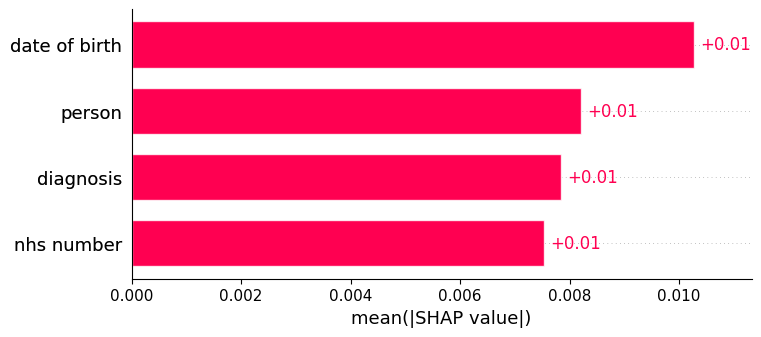

In [11]:
# Plot the mean shap values - global explanation
explainer.plot_global_explanation(exp_obj)

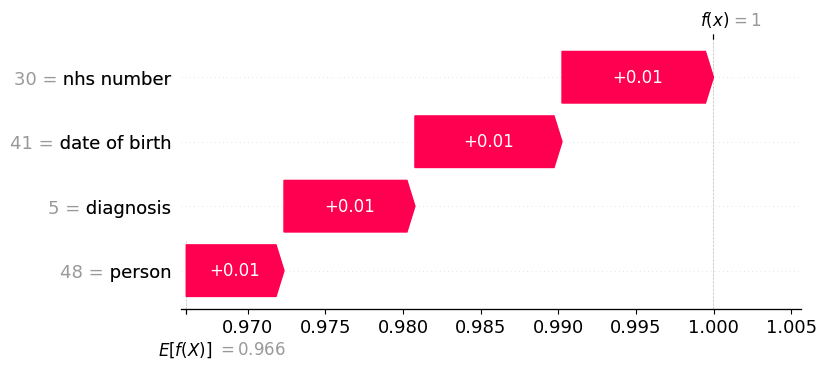

In [12]:
# Plot the local shap values for a particular record
explainer.plot_local_explanation(exp_obj, 49)